# Generalized Estimating Equations (GEE) Algorithm Using Statsmodels

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  500
Model:                                 GEE   No. clusters:                      100
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                   5
Family:                           Gaussian   Mean cluster size:                 5.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Thu, 06 Jun 2024   Scale:                           1.212
Covariance type:                    robust   Time:                         10:56:52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8726      0.090     20.717      0.000       1.695       2.050
time   

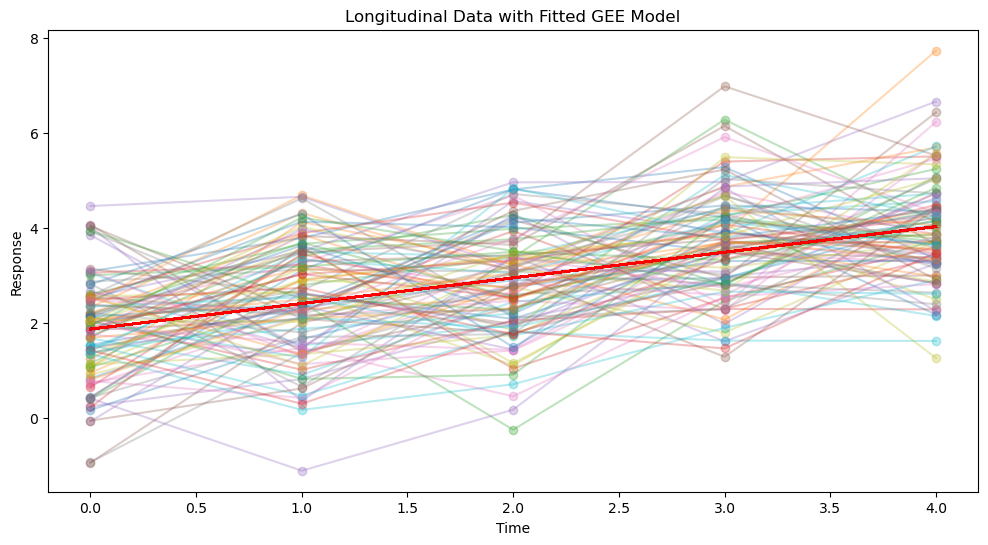

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.cov_struct import Exchangeable

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_subjects = 100
n_timepoints = 5

# Simulate subject IDs
subjects = np.arange(n_subjects)

# Simulate time points
time = np.tile(np.arange(n_timepoints), n_subjects)

# Simulate data
intercept = 2.0
slope = 0.5
subject_effects = np.random.normal(0, 0.5, n_subjects)
noise = np.random.normal(0, 1, n_subjects * n_timepoints)

# Create the response variable with a subject-specific intercept and a slope
y = intercept + slope * time + np.repeat(subject_effects, n_timepoints) + noise

# Create a DataFrame
data = pd.DataFrame({
    'subject': np.repeat(subjects, n_timepoints),
    'time': time,
    'y': y
})

# Fit the GEE model
model = GEE.from_formula("y ~ time", groups="subject", data=data, cov_struct=Exchangeable(), family=Gaussian())
result = model.fit()

# Print the summary
summary = result.summary()
print(summary)
summary_text = summary.as_text()

# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in subjects:
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)

# Plot the fitted values
fitted_values = result.fittedvalues
for subject in subjects:
    plt.plot(data[data['subject'] == subject]['time'], fitted_values[subject * n_timepoints:(subject + 1) * n_timepoints], 'r-', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Longitudinal Data with Fitted GEE Model')
plt.show()


# GEE Algorithm Without Statsmodels library

In [4]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_subjects = 100
n_timepoints = 5

# Simulate subject IDs
subjects = np.arange(n_subjects)

# Simulate time points
time = np.tile(np.arange(n_timepoints), n_subjects)

# Simulate data
intercept = 2.0
slope = 0.5
subject_effects = np.random.normal(0, 0.5, n_subjects)
noise = np.random.normal(0, 1, n_subjects * n_timepoints)

# Create the response variable with a subject-specific intercept and a slope
y = intercept + slope * time + np.repeat(subject_effects, n_timepoints) + noise

# Create a DataFrame
data = pd.DataFrame({
    'subject': np.repeat(subjects, n_timepoints),
    'time': time,
    'y': y
})

# Initialize parameters
beta = np.array([0.0, 0.0])  # Initial guess for the coefficients
max_iter = 100
tol = 1e-6
n = len(data)

X = np.column_stack((np.ones(n), data['time']))
y = data['y'].values
subjects = data['subject'].values

def working_correlation_matrix(rho, size):
    return rho * np.ones((size, size)) + (1 - rho) * np.eye(size)

def safe_corrcoef(x):
    if len(x) < 2:
        return 0
    corr = np.corrcoef(x)
    if corr.shape == (2, 2):
        return corr[0, 1]
    return 0

def gee_fit(X, y, subjects, max_iter=100, tol=1e-6):
    beta = np.zeros(X.shape[1])
    n_subjects = len(np.unique(subjects))
    subject_indices = [np.where(subjects == i)[0] for i in range(n_subjects)]
    
    for iteration in range(max_iter):
        eta = X.dot(beta)
        residuals = y - eta
        
        # Safely calculate correlation coefficient
        correlations = [safe_corrcoef(residuals[indices]) for indices in subject_indices]
        
        rho = np.mean(correlations)
        
        XtWX = np.zeros((X.shape[1], X.shape[1]))
        XtWy = np.zeros(X.shape[1])
        
        for indices in subject_indices:
            Xi = X[indices]
            yi = y[indices]
            Vi = np.linalg.inv(working_correlation_matrix(rho, len(indices)))
            XtWX += Xi.T.dot(Vi).dot(Xi)
            XtWy += Xi.T.dot(Vi).dot(yi)
        
        beta_new = np.linalg.solve(XtWX, XtWy)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    
    return beta, rho

beta, rho = gee_fit(X, y, subjects)

def robust_standard_errors(X, y, beta, subjects):
    n_subjects = len(np.unique(subjects))
    subject_indices = [np.where(subjects == i)[0] for i in range(n_subjects)]
    
    residuals = y - X.dot(beta)
    S = np.zeros((X.shape[1], X.shape[1]))
    XtX = np.zeros((X.shape[1], X.shape[1]))
    
    for indices in subject_indices:
        Xi = X[indices]
        ri = residuals[indices]
        XtX += Xi.T.dot(Xi)
        S += Xi.T.dot(np.outer(ri, ri)).dot(Xi)
    
    robust_cov = np.linalg.inv(XtX).dot(S).dot(np.linalg.inv(XtX))
    return np.sqrt(np.diag(robust_cov))

se = robust_standard_errors(X, y, beta, subjects)

print("Estimated beta:", beta)
print("Estimated standard errors:", se)

Estimated beta: [1.8726224  0.54000026]
Estimated standard errors: [0.09039063 0.03050519]


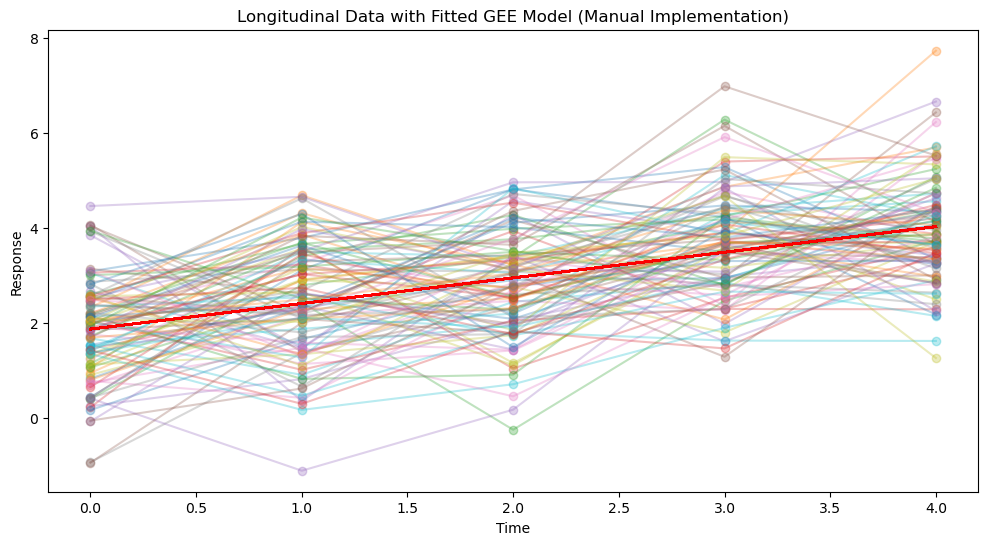

In [3]:
import matplotlib.pyplot as plt

# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)

# Plot the fitted values using the estimated coefficients
fitted_values = X.dot(beta)
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], fitted_values[subject * n_timepoints:(subject + 1) * n_timepoints], 'r-', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Longitudinal Data with Fitted GEE Model (Manual Implementation)')
plt.show()

# Linear Regression Implementation of Best Fit Line

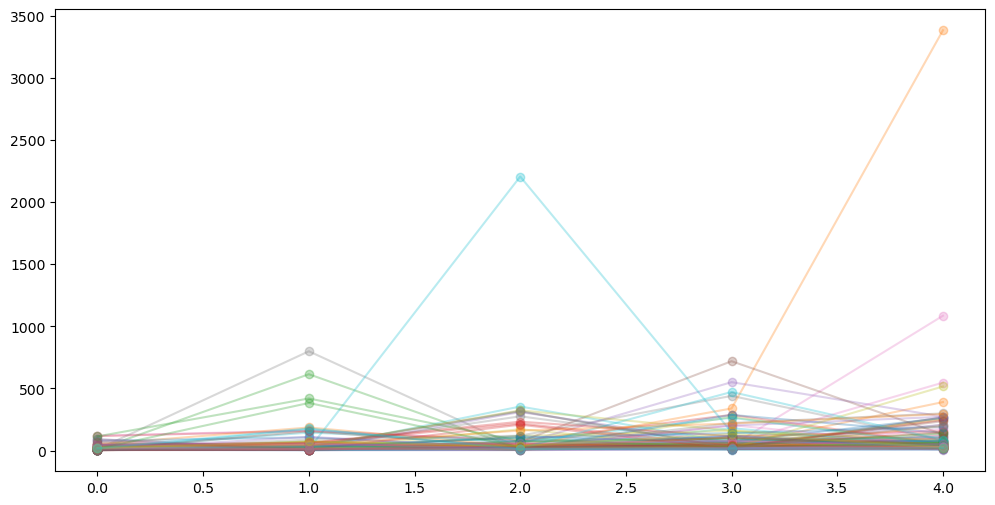

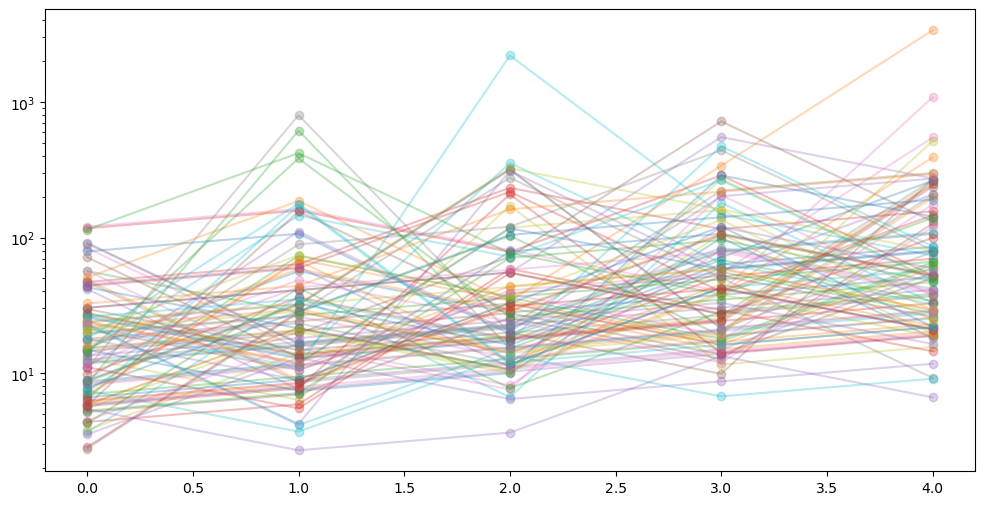

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_subjects = 100
n_timepoints = 5

# Simulate subject IDs
subjects = np.arange(n_subjects)

# Simulate time points
time = np.tile(np.arange(n_timepoints), n_subjects)

# Simulate data
intercept = 2.0
slope = 0.3
subject_effects = np.random.normal(0, 0.5, n_subjects)
noise = np.random.poisson(1, n_subjects * n_timepoints)

# Create the response variable with a subject-specific intercept and Poisson noise
y = np.exp(intercept + slope * time + np.repeat(subject_effects, n_timepoints) + noise)

# Create a DataFrame
data = pd.DataFrame({
    'subject': np.repeat(subjects, n_timepoints),
    'time': time,
    'y': y
})

# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)

# Plot the raw data log scale
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)
plt.yscale('log')

# Ordinary Least Squares (OLS) Estimation

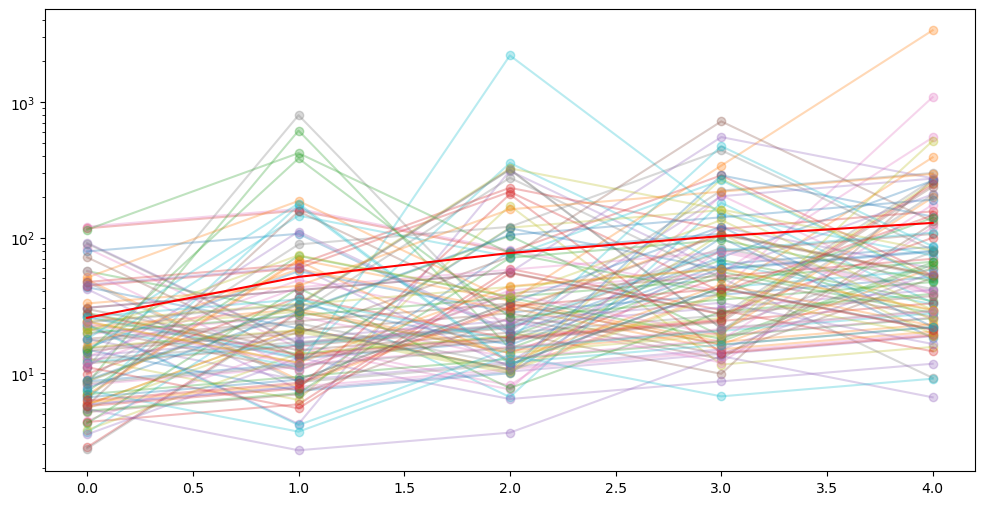

In [21]:
# Design matrix
X = np.column_stack((np.ones(len(data)), data['time']))
y = data['y'].values

# OLS estimation
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ y

# Predicted values
y_pred_ols = X @ beta_ols

# Residuals
residuals_ols = y - y_pred_ols

# OLS standard errors
n = X.shape[0]
p = X.shape[1]
sigma2 = np.sum(residuals_ols**2) / (n - p)
cov_matrix_ols = sigma2 * np.linalg.inv(X.T @ X)
se_ols = np.sqrt(np.diag(cov_matrix_ols))

# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)
plt.yscale('log')

# Plot the fitted values for each model
time_values = np.arange(n_timepoints)
X_plot = np.column_stack((np.ones(n_timepoints), time_values))

# OLS
y_pred_ols_plot = X_plot @ beta_ols
plt.plot(time_values, y_pred_ols_plot, 'r-', label='OLS')


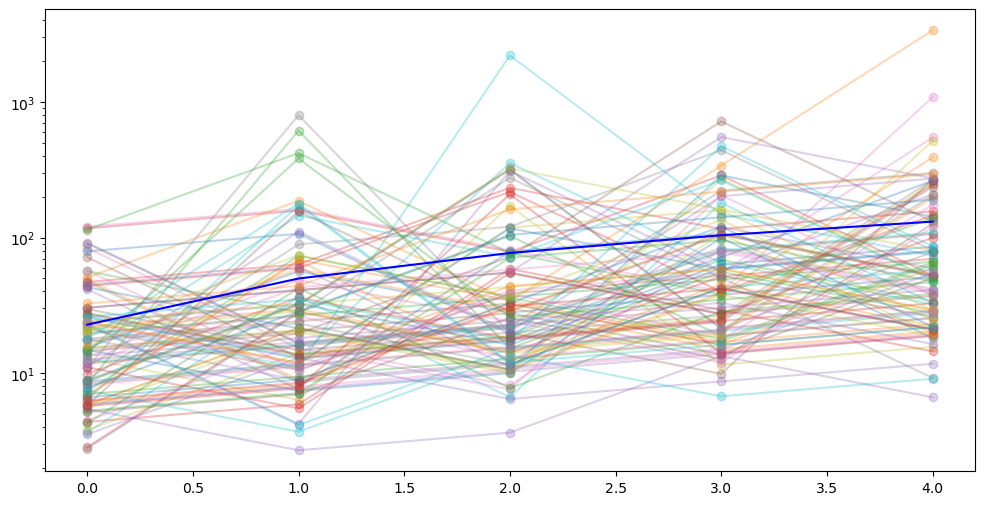

In [29]:
# Design matrix
X = np.column_stack((np.ones(len(data)), data['time']))
y = data['y'].values
X_wls = np.exp(X)

# OLS estimation
beta_wls = np.linalg.inv(X_wls.T @ X) @ X_wls.T @ y

# Predicted values
y_pred_wls = X_wls @ beta_wls

# Residuals
residuals_ols = y - y_pred_ols

# OLS standard errors
n = X_wls.shape[0]
p = X_wls.shape[1]
sigma2 = np.sum(residuals_ols**2) / (n - p)
cov_matrix_wls = sigma2 * np.linalg.inv(X_wls.T @ X_wls)
se_wls = np.sqrt(np.diag(cov_matrix_wls))

# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)

# Plot the fitted values for each model
time_values = np.arange(n_timepoints)
X_plot = np.column_stack((np.ones(n_timepoints), time_values))

# WLS
y_pred_wls_plot = X_plot @ beta_wls
plt.plot(time_values, y_pred_wls_plot, 'b-', label='WLS')
plt.yscale('log')


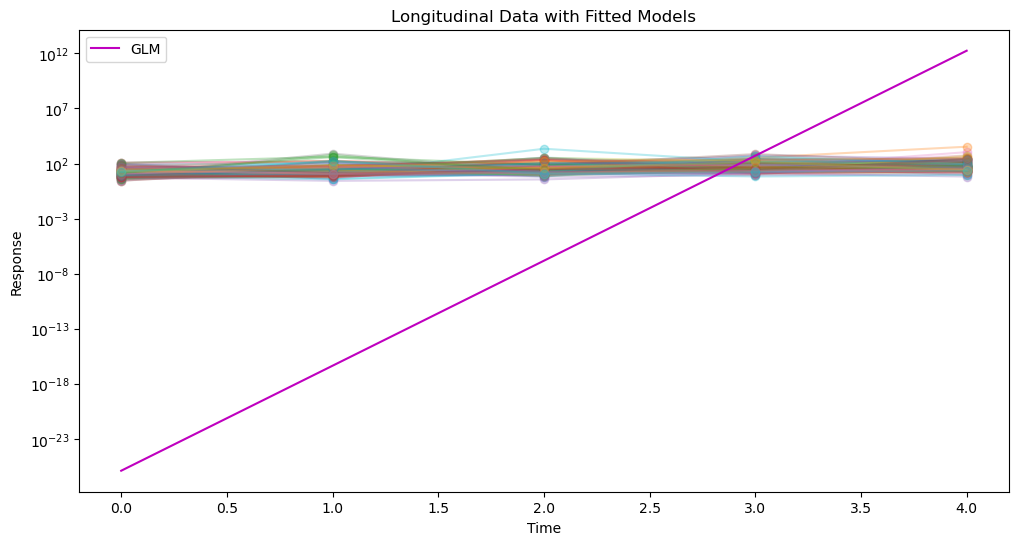

In [28]:
# GLM estimation using iteratively reweighted least squares
def glm_fit(X, y, family, max_iter=100, tol=1e-6):
    beta = np.zeros(X.shape[1])
    for iteration in range(max_iter):
        eta = X.dot(beta)
        mu = np.exp(eta) if family == "Poisson" else eta
        W = np.diag(mu)
        z = eta + (y - mu) / mu
        beta_new = np.linalg.solve(X.T @ W @ X, X.T @ W @ z)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    return beta

beta_glm = glm_fit(X, y, family="Poisson")

# Predicted values
y_pred_glm = np.exp(X @ beta_glm)  # Log link for Poisson

# Residuals
residuals_glm = y - y_pred_glm

# GLM standard errors (approximate)
W = np.diag(y_pred_glm)
cov_matrix_glm = np.linalg.inv(X.T @ W @ X)
se_glm = np.sqrt(np.diag(cov_matrix_glm))

# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)

# Plot the fitted values for each model
time_values = np.arange(n_timepoints)
X_plot = np.column_stack((np.ones(n_timepoints), time_values))

# GLM
y_pred_glm_plot = np.exp(X_plot @ beta_glm)
plt.plot(time_values, y_pred_glm_plot, 'm-', label='GLM')
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Longitudinal Data with Fitted Models')
plt.legend()
plt.show()



/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: Fu

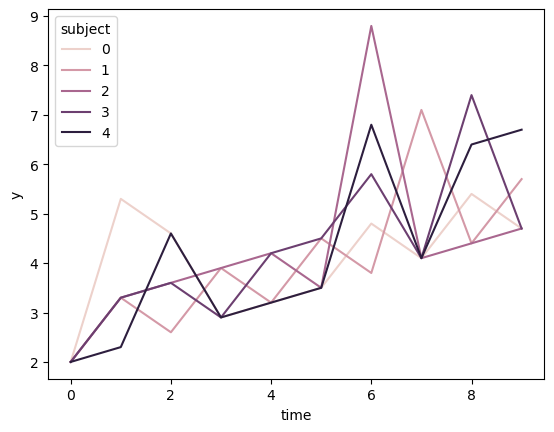

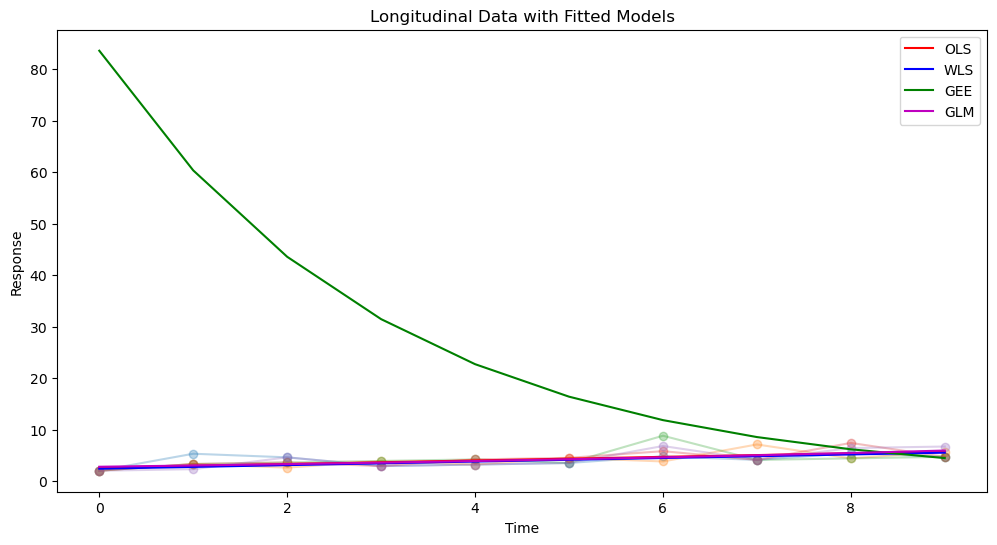

Text(0.5, 1.0, 'GEE Residuals Distribution')

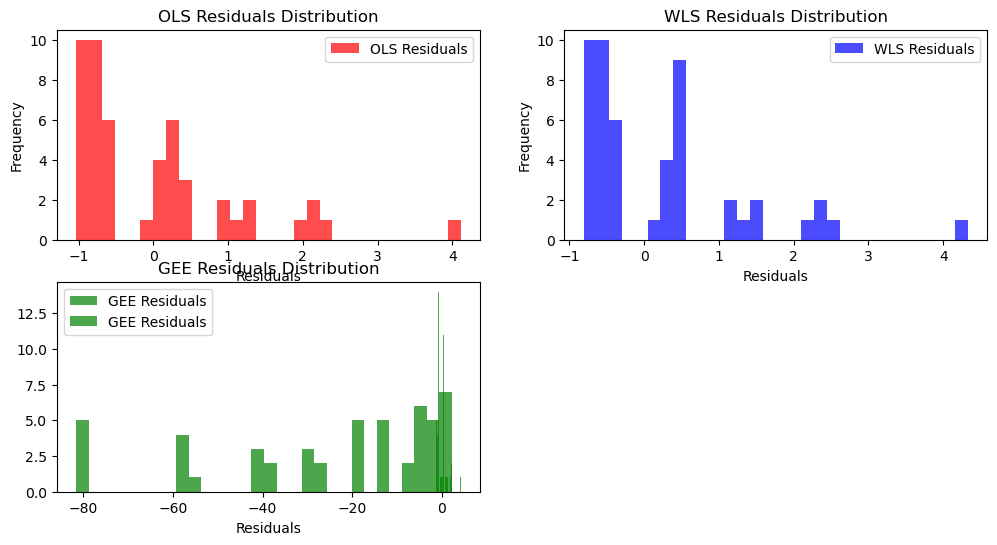

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_subjects = 5
n_timepoints = 10

# Simulate subject IDs
subjects = np.arange(n_subjects)

# Simulate time points
time = np.tile(np.arange(n_timepoints), n_subjects)

# Simulate data
intercept = 2.0
slope = 0.3
subject_effects = np.random.normal(0, 0.5, n_subjects)
noise = np.random.poisson(1, n_subjects * n_timepoints)

# Create the response variable with a subject-specific intercept and Poisson noise
y = intercept + slope * time + np.repeat(subject_effects, n_timepoints) + noise

# Create a DataFrame
data = pd.DataFrame({
    'subject': np.repeat(subjects, n_timepoints),
    'time': time,
    'y': y
})

# Plot the raw data
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x='time', y='y', hue='subject')
plt.show()

# Ordinary Least Squares (OLS) Implementation
# Design matrix
X = np.column_stack((np.ones(len(data)), data['time']))
y = data['y'].values

# OLS estimation
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ y

# Predicted values
y_pred_ols = X @ beta_ols

# Residuals
residuals_ols = y - y_pred_ols

# OLS standard errors
n = X.shape[0]
p = X.shape[1]
sigma2 = np.sum(residuals_ols**2) / (n - p)
cov_matrix_ols = sigma2 * np.linalg.inv(X.T @ X)
se_ols = np.sqrt(np.diag(cov_matrix_ols))

# Weighted Least Squares (WLS) Implementation
weights = 1 / y  # Using the inverse of y as weights

# Ensure weights are 1D
weights = weights.flatten()

# WLS estimation
W = np.diag(weights)
beta_wls = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y

# Predicted values
y_pred_wls = X @ beta_wls

# Residuals
residuals_wls = y - y_pred_wls

# WLS standard errors
sigma2_wls = np.sum(weights * residuals_wls**2) / (n - p)
cov_matrix_wls = sigma2_wls * np.linalg.inv(X.T @ W @ X)
se_wls = np.sqrt(np.diag(cov_matrix_wls))

# Generalized Estimating Equations (GEE) Implementation
def working_correlation_matrix(rho, size):
    return rho * np.ones((size, size)) + (1 - rho) * np.eye(size)

def safe_corrcoef(x):
    if len(x) < 2:
        return 0
    corr = np.corrcoef(x)
    if corr.shape == (2, 2):
        return corr[0, 1]
    return 0

def gee_fit(X, y, subjects, family, max_iter=100, tol=1e-6, reg=1e-5):
    beta = np.zeros(X.shape[1])
    n_subjects = len(np.unique(subjects))
    subject_indices = [np.where(subjects == i)[0] for i in range(n_subjects)]
    
    for iteration in range(max_iter):
        eta = X.dot(beta)
        mu = np.exp(eta) if family == "Poisson" else eta  # Log link for Poisson
        residuals = y - mu
        
        # Safely calculate correlation coefficient
        correlations = [safe_corrcoef(residuals[indices]) for indices in subject_indices]
        
        rho = np.mean(correlations)
        
        XtWX = np.zeros((X.shape[1], X.shape[1]))
        XtWy = np.zeros(X.shape[1])
        
        for indices in subject_indices:
            Xi = X[indices]
            yi = y[indices]
            mui = mu[indices]
            Vi = np.linalg.inv(working_correlation_matrix(rho, len(indices)))
            A_i = np.diag(mui)
            XtWX += Xi.T.dot(A_i).dot(Vi).dot(A_i).dot(Xi)
            XtWy += Xi.T.dot(A_i).dot(Vi).dot(A_i).dot(yi)
        
        XtWX += reg * np.eye(X.shape[1])  # Regularization to ensure invertibility
        beta_new = np.linalg.solve(XtWX, XtWy)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    
    return beta, rho

def robust_standard_errors(X, y, beta, subjects, family):
    n_subjects = len(np.unique(subjects))
    subject_indices = [np.where(subjects == i)[0] for i in range(n_subjects)]
    
    eta = X.dot(beta)
    mu = np.exp(eta) if family == "Poisson" else eta
    residuals = y - mu
    S = np.zeros((X.shape[1], X.shape[1]))
    XtX = np.zeros((X.shape[1], X.shape[1]))
    
    for indices in subject_indices:
        Xi = X[indices]
        ri = residuals[indices]
        mui = mu[indices]
        Ai = np.diag(mui)
        XtX += Xi.T.dot(Ai).dot(Xi)
        S += Xi.T.dot(Ai).dot(np.outer(ri, ri)).dot(Ai).dot(Xi)
    
    robust_cov = np.linalg.inv(XtX).dot(S).dot(np.linalg.inv(XtX))
    return np.sqrt(np.diag(robust_cov))

beta_gee, rho = gee_fit(X, y, subjects, family="Poisson")
se_gee = robust_standard_errors(X, y, beta_gee, subjects, family="Poisson")

# Residuals for GEE
eta_gee = X.dot(beta_gee)
mu_gee = np.exp(eta_gee)
residuals_gee = y - mu_gee

# Generalized Linear Model (GLM) Implementation
def glm_fit(X, y, family, max_iter=100, tol=1e-6):
    beta = np.zeros(X.shape[1])
    for iteration in range(max_iter):
        eta = X.dot(beta)
        mu = np.exp(eta) if family == "Poisson" else eta
        W = np.diag(mu)
        z = eta + (y - mu) / mu
        beta_new = np.linalg.solve(X.T @ W @ X, X.T @ W @ z)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    return beta

beta_glm = glm_fit(X, y, family="Poisson")

# Predicted values
y_pred_glm = np.exp(X @ beta_glm)  # Log link for Poisson

# Residuals
residuals_glm = y - y_pred_glm

# GLM standard errors (approximate)
W = np.diag(y_pred_glm)
cov_matrix_glm = np.linalg.inv(X.T @ W @ X)
se_glm = np.sqrt(np.diag(cov_matrix_glm))

# Visualization
# Plot the raw data
plt.figure(figsize=(12, 6))
for subject in np.unique(subjects):
    plt.plot(data[data['subject'] == subject]['time'], data[data['subject'] == subject]['y'], 'o-', alpha=0.3)

# Plot the fitted values for each model
time_values = np.arange(n_timepoints)
X_plot = np.column_stack((np.ones(n_timepoints), time_values))

# OLS
y_pred_ols_plot = X_plot @ beta_ols
plt.plot(time_values, y_pred_ols_plot, 'r-', label='OLS')

# WLS
y_pred_wls_plot = X_plot @ beta_wls
plt.plot(time_values, y_pred_wls_plot, 'b-', label='WLS')

# GEE
y_pred_gee_plot = np.exp(X_plot @ beta_gee)
plt.plot(time_values, y_pred_gee_plot, 'g-', label='GEE')

# GLM
y_pred_glm_plot = np.exp(X_plot @ beta_glm)
plt.plot(time_values, y_pred_glm_plot, 'm-', label='GLM')

plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Longitudinal Data with Fitted Models')
plt.legend()
plt.show()

# Residual Distribution Visualization
plt.figure(figsize=(12, 6))

# OLS Residuals
plt.subplot(2, 2, 1)
plt.hist(residuals_ols, bins=bins, color='red', alpha=0.7, label='OLS Residuals')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('OLS Residuals Distribution')

# WLS Residuals
plt.subplot(2, 2, 2)
plt.hist(residuals_wls, bins=bins, color='blue', alpha=0.7, label='WLS Residuals')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('WLS Residuals Distribution')

# GLM Residuals
plt.subplot(2, 2, 3)
plt.hist(residuals_glm, bins=bins, color='green', alpha=0.7, label='GEE Residuals')
plt.legend()
plt.xlabel('Residuals')
plt.title('GLM Residuals Distribution')

# GEE Residuals
plt.subplot(2, 2, 3)
plt.hist(residuals_gee, bins=bins, color='green', alpha=0.7, label='GEE Residuals')
plt.legend()
plt.xlabel('Residuals')
plt.title('GEE Residuals Distribution')

# GEE Vs. GLM

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit

class GLM:
    def __init__(self, family, link_function):
        self.family = family
        self.link_function = link_function
        self.beta = None

    def fit(self, X, y, max_iter=100, tol=1e-6):
        n_samples, n_features = X.shape
        self.beta = np.zeros(n_features)
        
        for iter in range(max_iter):
            eta = X @ self.beta
            mu = self.link_function.inverse(eta)
            W = np.diag(self.link_function.derivative(mu)**2 / self.family.variance(mu))
            z = eta + (y - mu) / self.link_function.derivative(mu)
            
            beta_new = np.linalg.solve(X.T @ W @ X, X.T @ W @ z)
            
            if np.linalg.norm(beta_new - self.beta) < tol:
                break
            
            self.beta = beta_new
        
        return self.beta

    def predict(self, X):
        eta = X @ self.beta
        return self.link_function.inverse(eta)

class GEE:
    def __init__(self, family, link_function, corr_structure):
        self.family = family
        self.link_function = link_function
        self.corr_structure = corr_structure
        self.beta = None

    def fit(self, X, y, groups, max_iter=100, tol=1e-6):
        unique_groups = np.unique(groups)
        n_features = X.shape[1]
        self.beta = np.zeros(n_features)
        
        for iter in range(max_iter):
            score = np.zeros(n_features)
            fisher_info = np.zeros((n_features, n_features))
            
            for group in unique_groups:
                group_idx = (groups == group)
                X_g = X[group_idx]
                y_g = y[group_idx]
                eta_g = X_g @ self.beta
                mu_g = self.link_function.inverse(eta_g)
                A_g = np.diag(np.sqrt(self.family.variance(mu_g)))
                R_g = self.corr_structure(len(y_g))
                V_g = A_g @ R_g @ A_g + np.eye(len(y_g)) * 1e-6  # Ensure V_g is not singular
                D_g = np.diag(self.link_function.derivative(mu_g)) @ X_g
                
                try:
                    V_g_inv = np.linalg.inv(V_g)
                except np.linalg.LinAlgError:
                    print(f"Singular matrix for group {group}")
                    continue
                
                score += D_g.T @ V_g_inv @ (y_g - mu_g)
                fisher_info += D_g.T @ V_g_inv @ D_g
            
            beta_new = self.beta + np.linalg.solve(fisher_info, score)
            
            if np.linalg.norm(beta_new - self.beta) < tol:
                break
            
            self.beta = beta_new
        
        return self.beta

    def predict(self, X):
        eta = X @ self.beta
        return self.link_function.inverse(eta)

class OLS:
    def __init__(self):
        self.beta = None

    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0]), X))
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y
        return self.beta

    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))
        return X @ self.beta

In [161]:
class Binomial:
    def variance(self, mu):
        return mu * (1 - mu)

class Poisson:
    def variance(self, mu):
        return mu

class Gamma:
    def variance(self, mu):
        return mu**2

class Normal:
    def variance(self, mu):
        return np.ones_like(mu)

class Logit:
    @staticmethod
    def inverse(eta):
        return expit(eta)
    
    @staticmethod
    def derivative(mu):
        return mu * (1 - mu)

class Log:
    @staticmethod
    def inverse(eta):
        return np.exp(eta)
    
    @staticmethod
    def derivative(mu):
        return mu

class Identity:
    @staticmethod
    def inverse(eta):
        return eta
    
    @staticmethod
    def derivative(mu):
        return np.ones_like(mu)

class Inverse:
    @staticmethod
    def inverse(eta):
        return 1 / eta
    
    @staticmethod
    def derivative(mu):
        return -1 / mu**2

In [162]:
### Define Correlation Structure ###
def independence(n):
    return np.eye(n)

def exchangeable(n, alpha=0.5):
    return np.full((n, n), alpha) + np.eye(n) * (1 - alpha)

def autoregressive(n, rho=0.5):
    return rho ** np.abs(np.subtract.outer(np.arange(n), np.arange(n)))

def unstructured(n):
    random_matrix = np.random.randn(n, n)
    corr = np.dot(random_matrix, random_matrix.T)
    corr /= np.sqrt(np.outer(np.diag(corr), np.diag(corr)))
    return corr

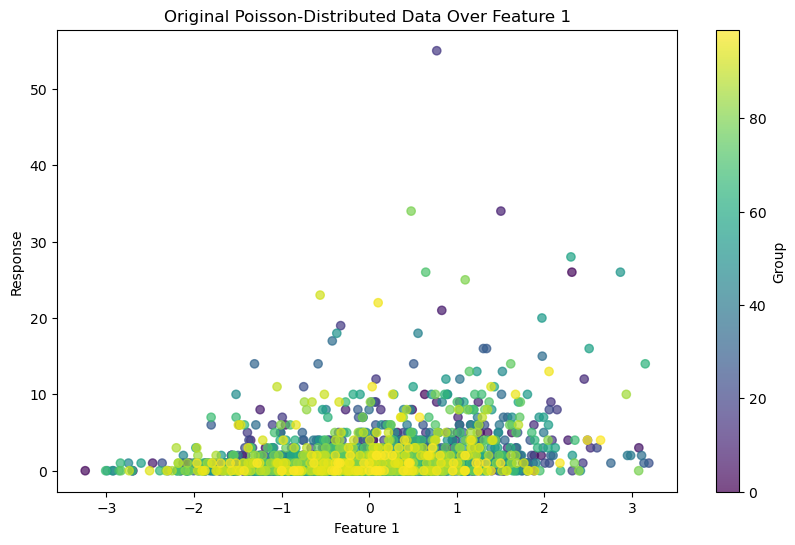

In [163]:
def generate_data(n_groups, n_obs_per_group, n_features, true_beta, distribution='poisson'):
    # np.random.seed(1)
    X = np.random.randn(n_groups * n_obs_per_group, n_features)
    y = np.zeros(n_groups * n_obs_per_group)
    groups = np.repeat(np.arange(n_groups), n_obs_per_group)
    
    for i in range(n_groups):
        group_idx = (groups == i)
        X_g = X[group_idx]
        eta_g = X_g @ true_beta
        
        # Link functions for given distribution
        if distribution == 'poisson':
            mu_g = np.exp(eta_g)
            y[group_idx] = np.random.poisson(mu_g)
        elif distribution == 'binomial':
            mu_g = expit(eta_g)
            y[group_idx] = np.random.binomial(1, mu_g)
        elif distribution == 'normal':
            mu_g = eta_g
            y[group_idx] = np.random.normal(mu_g, 1)
        elif distribution == 'gamma':
            mu_g = np.exp(eta_g)
            y[group_idx] = np.random.gamma(shape=2, scale=mu_g/2)  # mean=mu_g, variance=mu_g^2/shape
        else:
            raise ValueError("Unsupported distribution type")
    
    return X, y, groups

n_groups = 100
n_obs_per_group = 20
n_features = 3
true_beta = np.array([0.5, -1.0, 0.3])

# Generate Poisson-distributed data
X, y, groups = generate_data(n_groups, n_obs_per_group, n_features, true_beta, distribution='poisson')

# Plot the original data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], y, c=groups, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Group')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Original Poisson-Distributed Data Over Feature 1')
plt.show()

In [164]:
# Fit GLM
glm = GLM(family=Poisson(), link_function=Log())
glm_beta = glm.fit(X, y)
print("GLM Estimated coefficients:\n", glm_beta)

# Fit GEE with exchangeable correlation structure
gee = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: exchangeable(n, alpha=0.5))
gee_beta = gee.fit(X, y, groups)
print("GEE (Exchangeable) Estimated coefficients:\n", gee_beta)

# Fit GEE with autoregressive correlation structure
gee_ar = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: autoregressive(n, rho=0.5))
gee_ar_beta = gee_ar.fit(X, y, groups)
print("GEE (Autoregressive) Estimated coefficients:\n", gee_ar_beta)

# Fit GEE with unstructured correlation structure
gee_un = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: unstructured(n))
gee_un_beta = gee_un.fit(X, y, groups)
print("GEE (Unstructured) Estimated coefficients:\n", gee_un_beta)

# Fit GEE with independent correlation structure
gee_ind = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: independence(n))
gee_ind_beta = gee_ind.fit(X, y, groups)
print("GEE (Independent) Estimated coefficients:\n", gee_ind_beta)

# Fit OLS
ols = OLS()
ols_beta = ols.fit(X, y)
print("OLS Estimated coefficients:\n", ols_beta)

GLM Estimated coefficients:
 [ 0.46874109 -1.03521473  0.28025992]
GEE (Exchangeable) Estimated coefficients:
 [ 0.46895363 -1.03762734  0.27708725]
GEE (Autoregressive) Estimated coefficients:
 [ 0.4630195  -1.03885425  0.28772562]
GEE (Unstructured) Estimated coefficients:
 [ 0.45938422 -1.09431215  0.25803195]
GEE (Independent) Estimated coefficients:
 [ 0.46874109 -1.03521471  0.28025992]
OLS Estimated coefficients:
 [ 1.92824256  0.83944788 -1.89736931  0.57381873]


In [165]:
# Predict using GLM
y_pred_glm = glm.predict(X)

# Predict using GEE (Exchangeable)
y_pred_gee = gee.predict(X)

# Predict using GEE (Autoregressive)
y_pred_gee_ar = gee_ar.predict(X)

# Predict using GEE (Unstructured)
y_pred_gee_un = gee_un.predict(X)

# Predict using GEE (Independent)
y_pred_gee_ind = gee_ind.predict(X)

# Predict using OLS
y_pred_ols = ols.predict(X)

# Calculate residuals
residuals_glm = y - y_pred_glm
residuals_gee = y - y_pred_gee
residuals_gee_ar = y - y_pred_gee_ar
residuals_gee_un = y - y_pred_gee_un
residuals_gee_ind = y - y_pred_gee_ind
residuals_ols = y - y_pred_ols

# Calculate calibration data
def calibration_data(y, y_pred, n_bins=10):
    bins = np.linspace(0, y_pred.max(), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    actual = np.zeros(n_bins)
    predicted = np.zeros(n_bins)
    for i in range(n_bins):
        idx = (y_pred >= bins[i]) & (y_pred < bins[i + 1])
        actual[i] = y[idx].mean() if np.any(idx) else np.nan
        predicted[i] = bin_centers[i]
    return predicted, actual

pred_glm, act_glm = calibration_data(y, y_pred_glm)
pred_gee, act_gee = calibration_data(y, y_pred_gee)
pred_gee_ar, act_gee_ar = calibration_data(y, y_pred_gee_ar)
pred_gee_un, act_gee_un = calibration_data(y, y_pred_gee_un)
pred_gee_ind, act_gee_ind = calibration_data(y, y_pred_gee_ind)
pred_ols, act_ols = calibration_data(y, y_pred_ols)

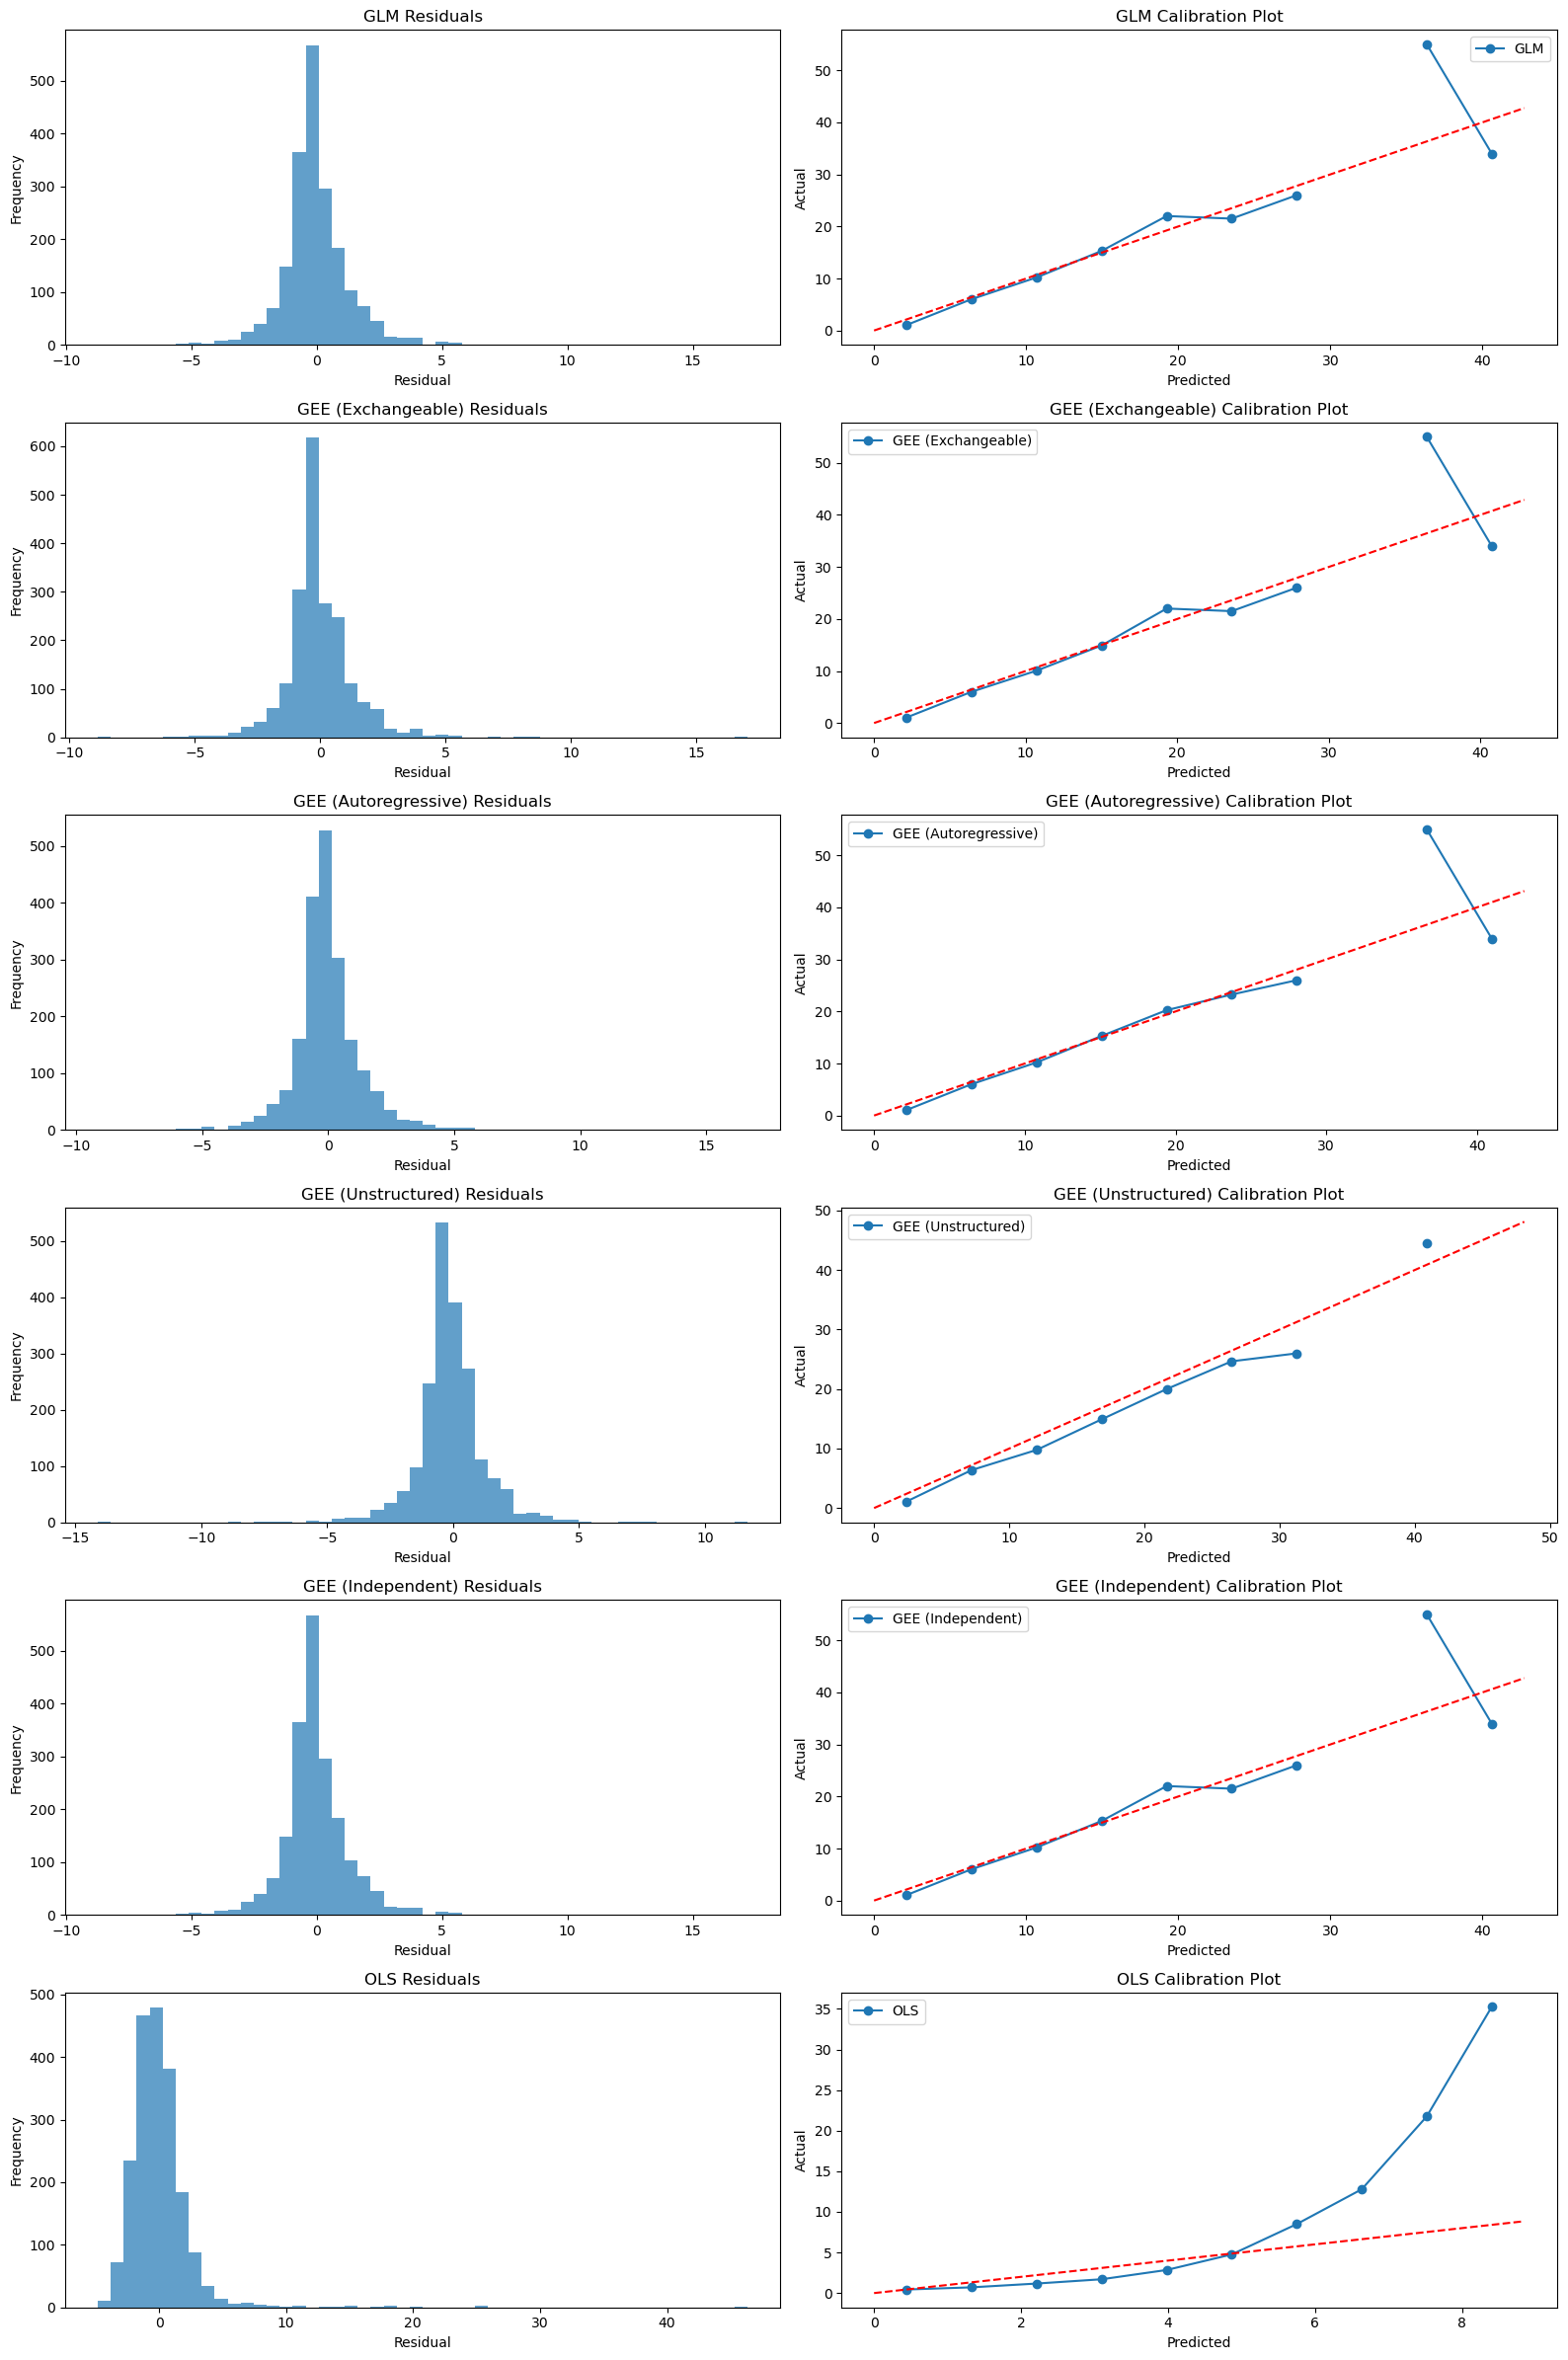

In [166]:
bins = 50

# Plotting residual histograms and calibration plots
plt.figure(figsize=(16, 24))

# Residual histograms
plt.subplot(6, 2, 1)
plt.hist(residuals_glm, bins=bins, alpha=0.7)
plt.title('GLM Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(6, 2, 3)
plt.hist(residuals_gee, bins=bins, alpha=0.7)
plt.title('GEE (Exchangeable) Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(6, 2, 5)
plt.hist(residuals_gee_ar, bins=bins, alpha=0.7)
plt.title('GEE (Autoregressive) Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(6, 2, 7)
plt.hist(residuals_gee_un, bins=bins, alpha=0.7)
plt.title('GEE (Unstructured) Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(6, 2, 9)
plt.hist(residuals_gee_ind, bins=bins, alpha=0.7)
plt.title('GEE (Independent) Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.subplot(6, 2, 11)
plt.hist(residuals_ols, bins=bins, alpha=0.7)
plt.title('OLS Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# Calibration plots
plt.subplot(6, 2, 2)
plt.plot(pred_glm, act_glm, 'o-', label='GLM')
plt.plot([0, y_pred_glm.max()], [0, y_pred_glm.max()], 'r--')
plt.title('GLM Calibration Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

plt.subplot(6, 2, 4)
plt.plot(pred_gee, act_gee, 'o-', label='GEE (Exchangeable)')
plt.plot([0, y_pred_gee.max()], [0, y_pred_gee.max()], 'r--')
plt.title('GEE (Exchangeable) Calibration Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

plt.subplot(6, 2, 6)
plt.plot(pred_gee_ar, act_gee_ar, 'o-', label='GEE (Autoregressive)')
plt.plot([0, y_pred_gee_ar.max()], [0, y_pred_gee_ar.max()], 'r--')
plt.title('GEE (Autoregressive) Calibration Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

plt.subplot(6, 2, 8)
plt.plot(pred_gee_un, act_gee_un, 'o-', label='GEE (Unstructured)')
plt.plot([0, y_pred_gee_un.max()], [0, y_pred_gee_un.max()], 'r--')
plt.title('GEE (Unstructured) Calibration Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

plt.subplot(6, 2, 10)
plt.plot(pred_gee_ind, act_gee_ind, 'o-', label='GEE (Independent)')
plt.plot([0, y_pred_gee_ind.max()], [0, y_pred_gee_ind.max()], 'r--')
plt.title('GEE (Independent) Calibration Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

plt.subplot(6, 2, 12)
plt.plot(pred_ols, act_ols, 'o-', label='OLS')
plt.plot([0, y_pred_ols.max()], [0, y_pred_ols.max()], 'r--')
plt.title('OLS Calibration Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

plt.tight_layout()
plt.show()


In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit

# Functions to calculate R-squared, MSE, AIC, and BIC
def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calculate_aic_bic(y_true, y_pred, n_params):
    residuals = y_true - y_pred
    sse = np.sum(np.square(residuals))
    n = len(y_true)
    aic_value = 2 * n_params + n * np.log(sse / n)
    bic_value = n_params * np.log(n) + n * np.log(sse / n)
    return aic_value, bic_value

# Fit Models and Calculate Metrics
models = {
    'GLM': glm,
    'GEE (Exchangeable)': gee,
    'GEE (Autoregressive)': gee_ar,
    'GEE (Unstructured)': gee_un,
    'GEE (Independent)': gee_ind,
    'OLS': ols
}

predictions = {
    'GLM': y_pred_glm,
    'GEE (Exchangeable)': y_pred_gee,
    'GEE (Autoregressive)': y_pred_gee_ar,
    'GEE (Unstructured)': y_pred_gee_un,
    'GEE (Independent)': y_pred_gee_ind,
    'OLS': y_pred_ols
}

metrics = {}
for model_name, model in models.items():
    y_pred = predictions[model_name]
    r_squared = calculate_r_squared(y, y_pred)
    mse = calculate_mse(y, y_pred)
    n_params = len(model.beta)
    aic_value, bic_value = calculate_aic_bic(y, y_pred, n_params)
    metrics[model_name] = {
        'R-squared': r_squared,
        'MSE': mse,
        'AIC': aic_value,
        'BIC': bic_value
    }

metrics_df = pd.DataFrame(metrics).T
metrics_df

R-squared       MSE          AIC          BIC
GLM                    0.831858  1.830114  1214.756820  1231.559527
GEE (Exchangeable)     0.831932  1.829307  1213.874384  1230.677092
GEE (Autoregressive)   0.831757  1.831214  1215.958102  1232.760809
GEE (Unstructured)     0.822263  1.934549  1325.748623  1342.551330
GEE (Independent)      0.831858  1.830114  1214.756827  1231.559535
OLS                    0.419352  6.319970  3695.428942  3717.832552

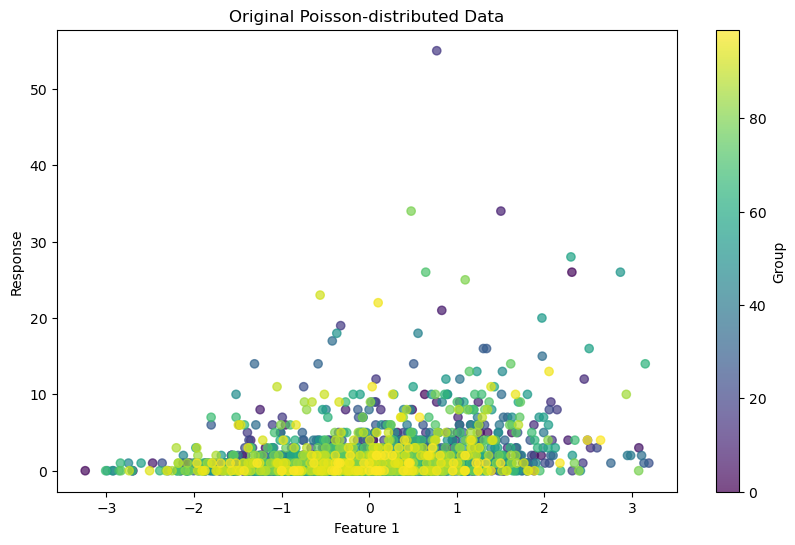

/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: Fu

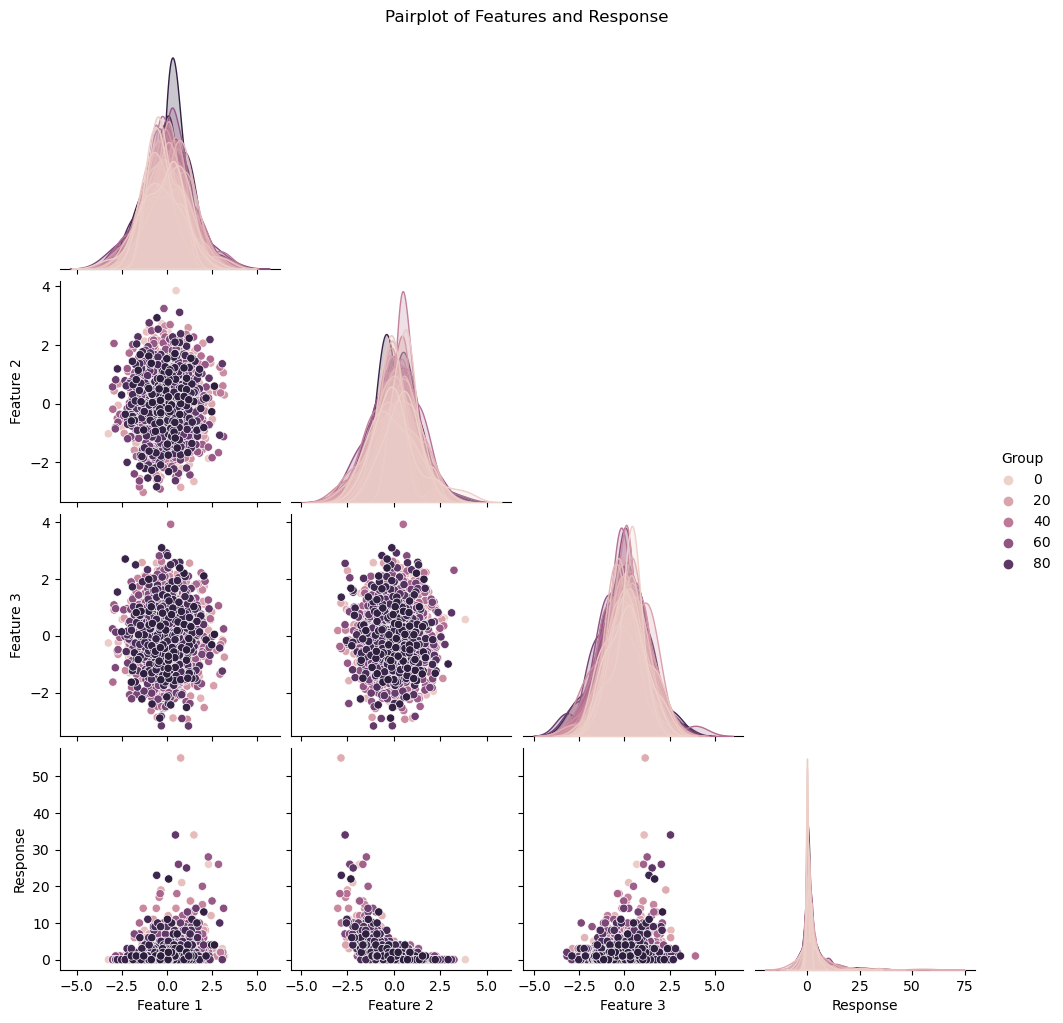

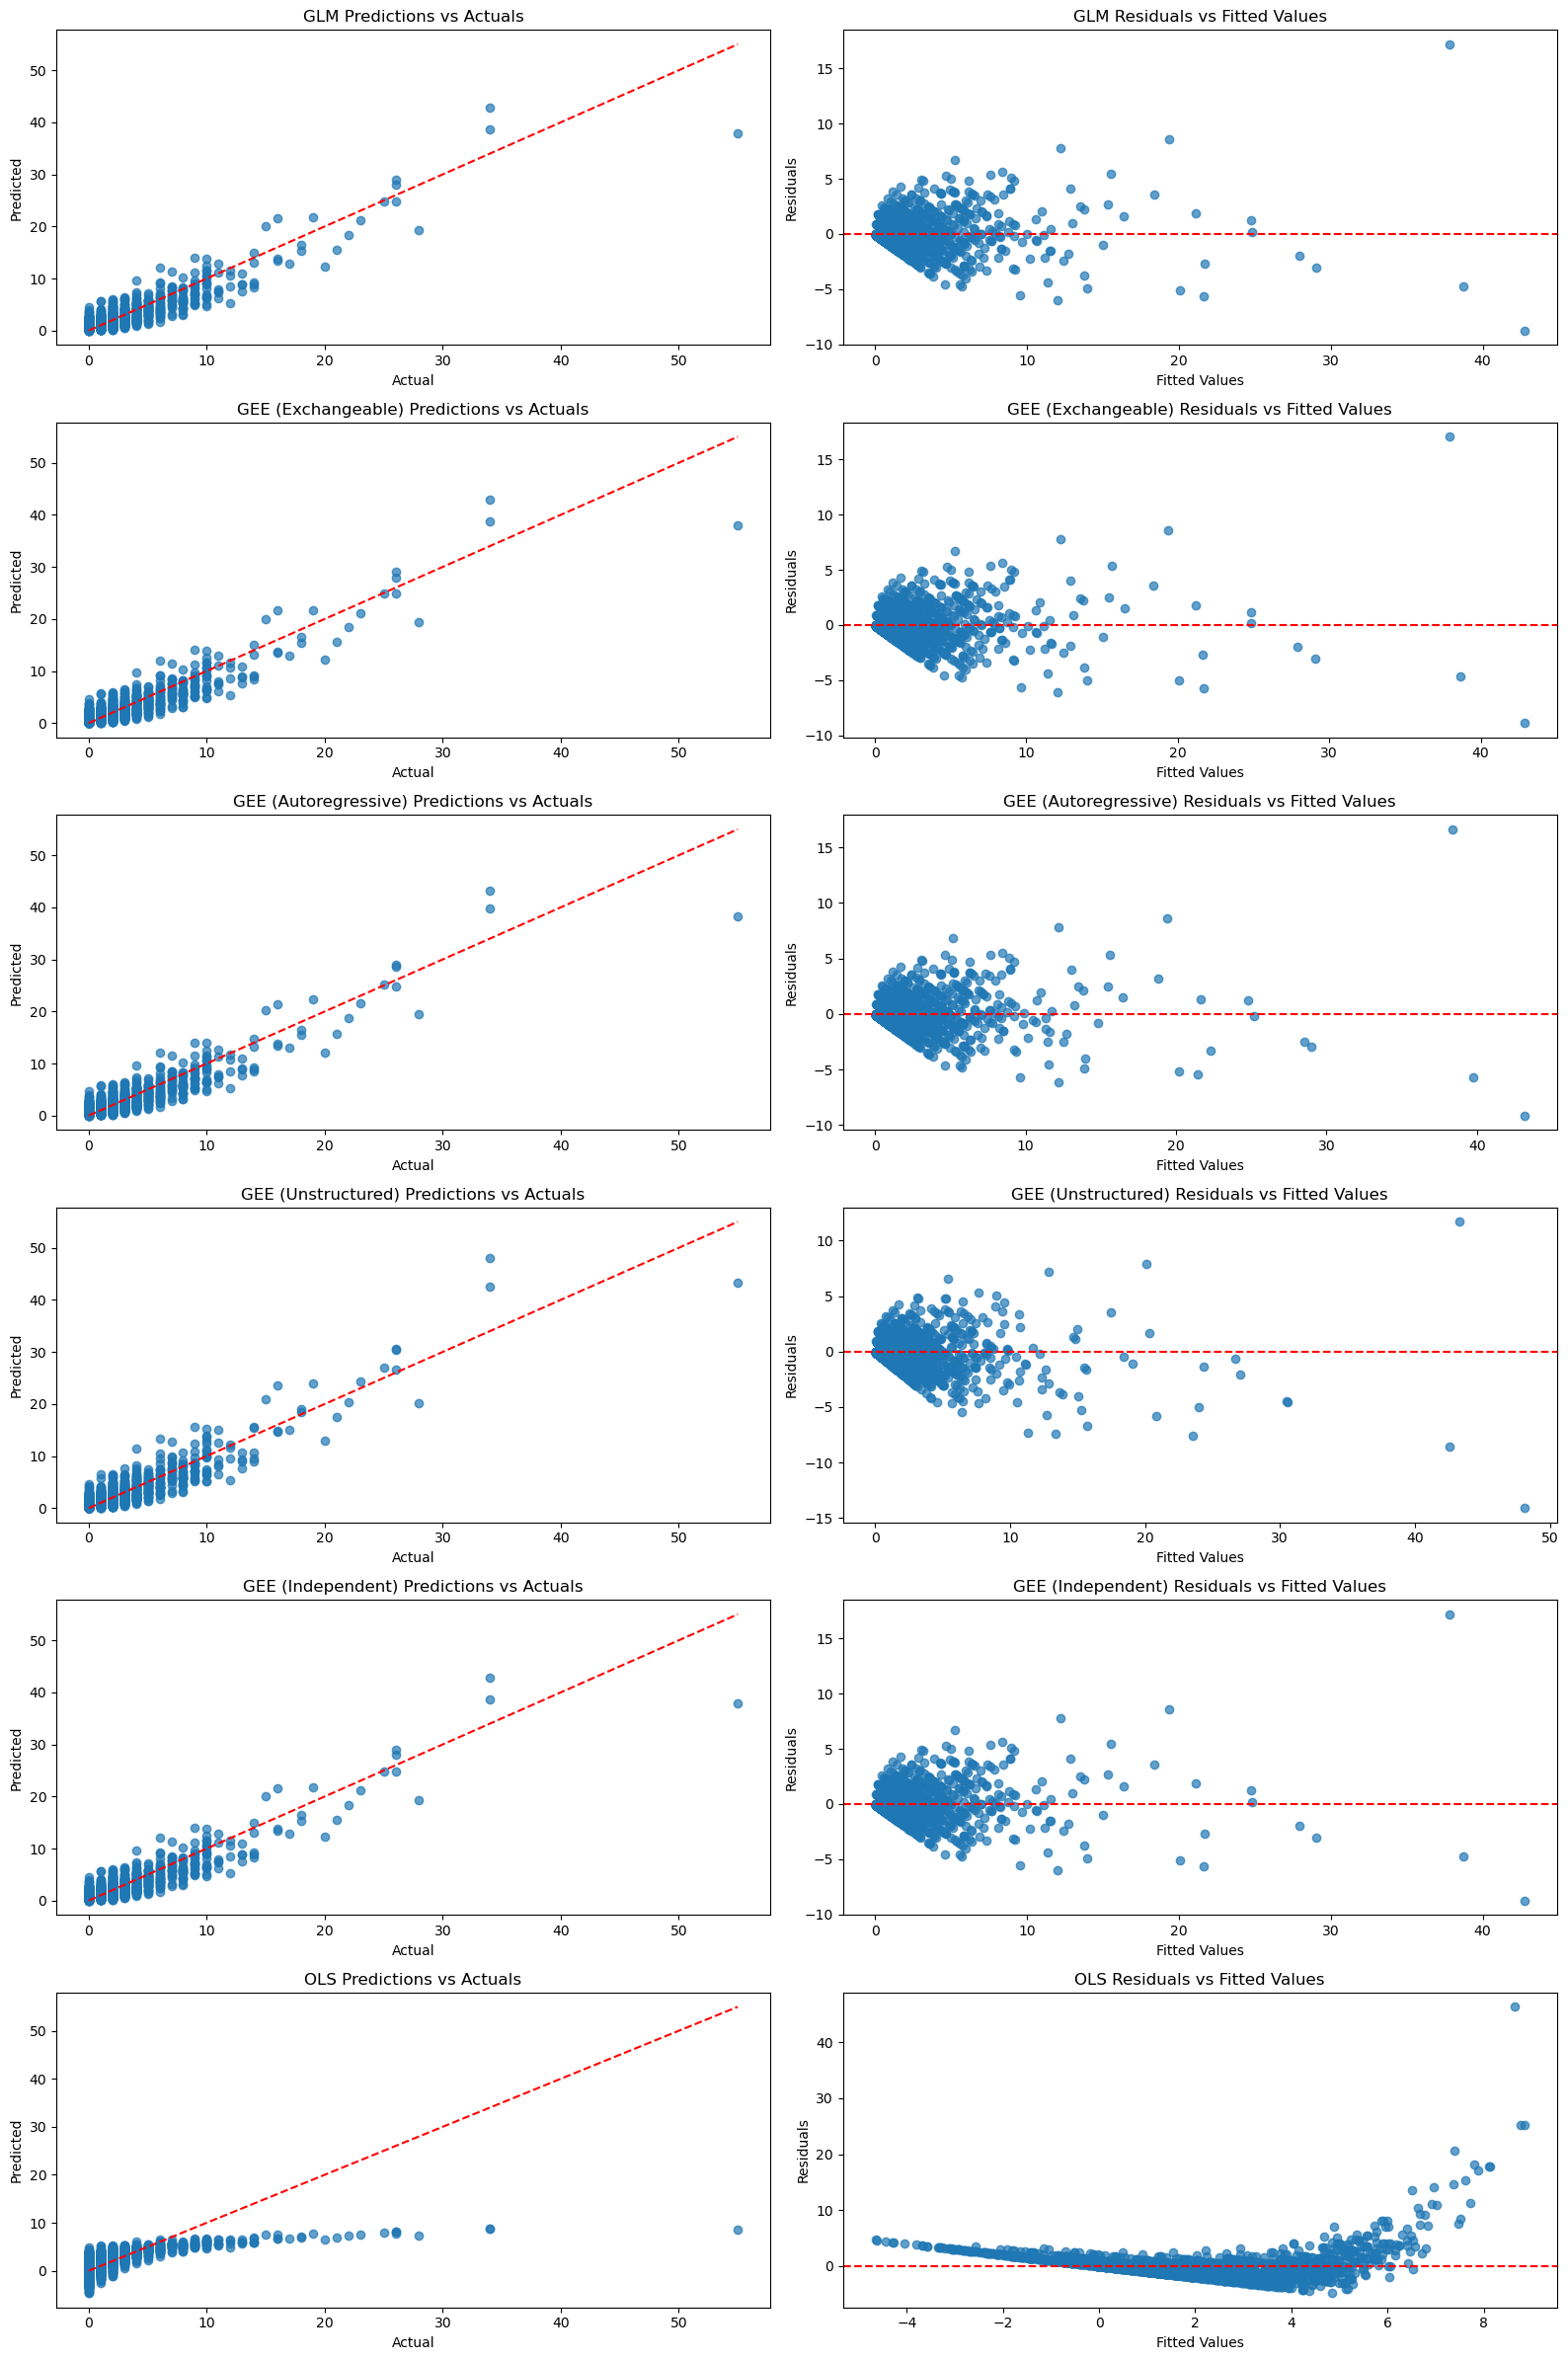

In [168]:
import seaborn as sns

# Scatter Plot of the Original Data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], y, c=groups, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Group')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Original Poisson-distributed Data')
plt.show()

# Pairplot to Visualize Relationships Between Features and the Response
df = pd.DataFrame(X, columns=[f'Feature {i+1}' for i in range(n_features)])
df['Response'] = y
df['Group'] = groups
sns.pairplot(df, hue='Group', corner=True)
plt.suptitle('Pairplot of Features and Response', y=1.02)
plt.show()

# Model Predictions vs. Actual Data for Each Model
plt.figure(figsize=(16, 24))

# Predictions vs Actuals
models = {
    'GLM': (y_pred_glm, residuals_glm),
    'GEE (Exchangeable)': (y_pred_gee, residuals_gee),
    'GEE (Autoregressive)': (y_pred_gee_ar, residuals_gee_ar),
    'GEE (Unstructured)': (y_pred_gee_un, residuals_gee_un),
    'GEE (Independent)': (y_pred_gee_ind, residuals_gee_ind),
    'OLS': (y_pred_ols, residuals_ols)
}

i = 1
for model_name, (pred, res) in models.items():
    plt.subplot(6, 2, i)
    plt.scatter(y, pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name} Predictions vs Actuals')
    i += 2

# Residuals vs. Fitted Values
i = 2
for model_name, (pred, res) in models.items():
    plt.subplot(6, 2, i)
    plt.scatter(pred, res, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residuals vs Fitted Values')
    i += 2

plt.tight_layout()
plt.show()

First 10 rows of design matrix (X):
 [[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783]
 [-0.56228753 -1.01283112  0.31424733]
 [-0.90802408 -1.4123037   1.46564877]
 [-0.2257763   0.0675282  -1.42474819]
 [-0.54438272  0.11092259 -1.15099358]
 [ 0.37569802 -0.60063869 -0.29169375]]
First 10 elements of response vector (y):
 [-1.32687962  0.06504221 -0.53227617  2.48266645  2.07333916 -0.50952001
  1.88402258 -2.1551448   0.35427903  0.22985492]
First 10 group identifiers:
 [0 0 0 0 0 0 0 0 0 0]
OLS Estimated coefficients:
 [-0.01802526  0.51702509 -1.02659158  0.26189863]


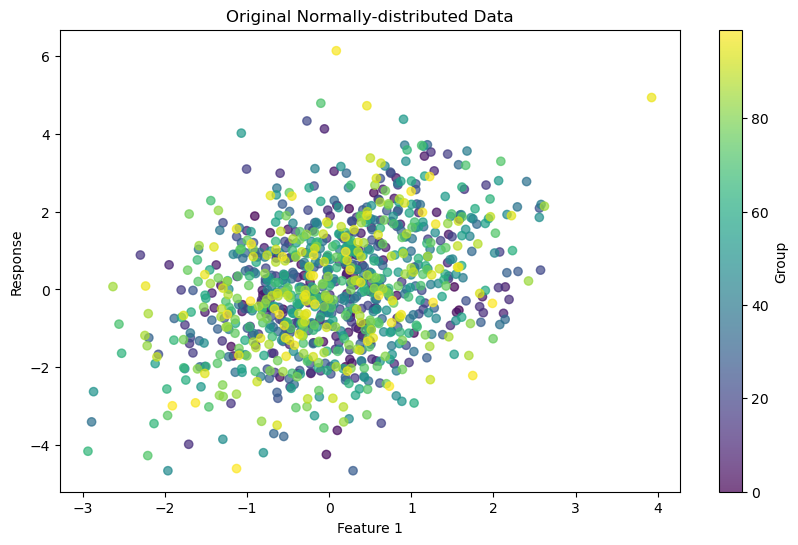

/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: Fu

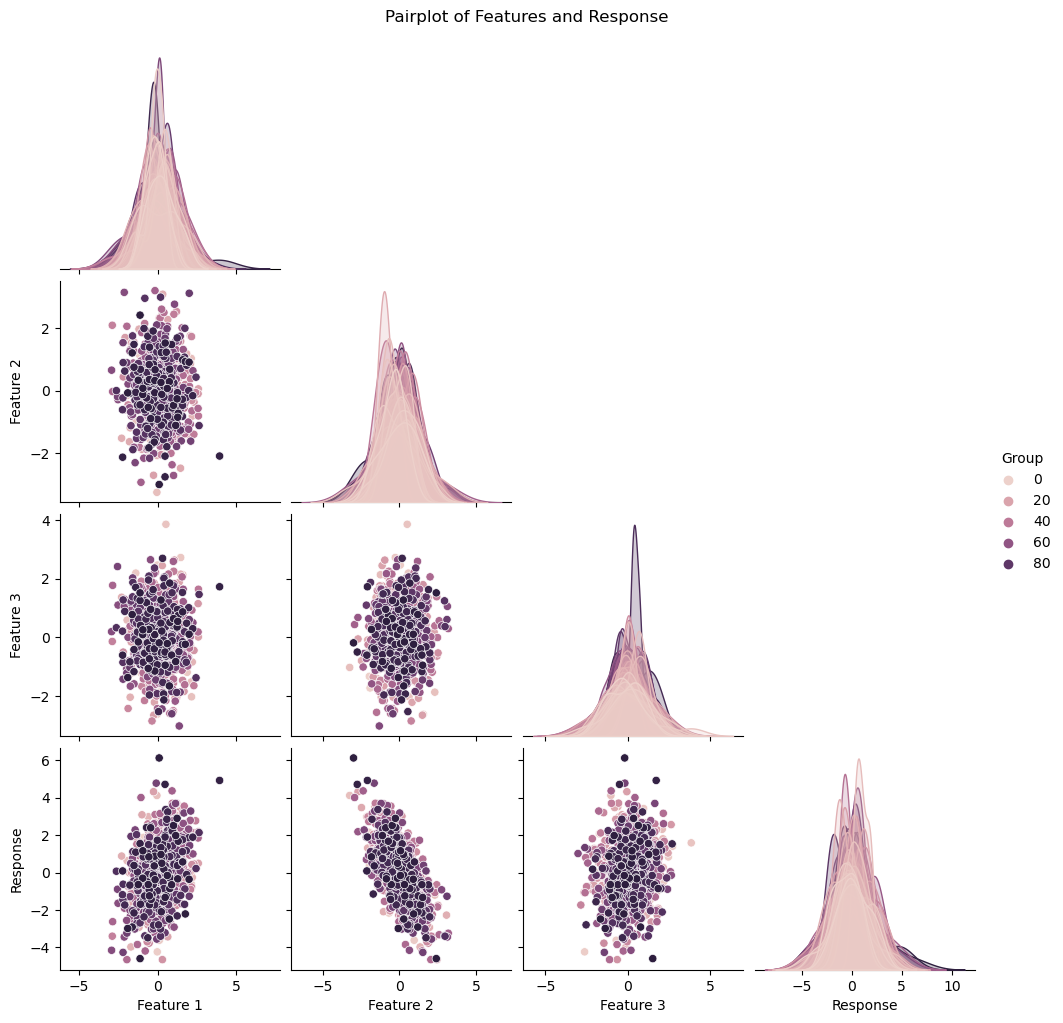

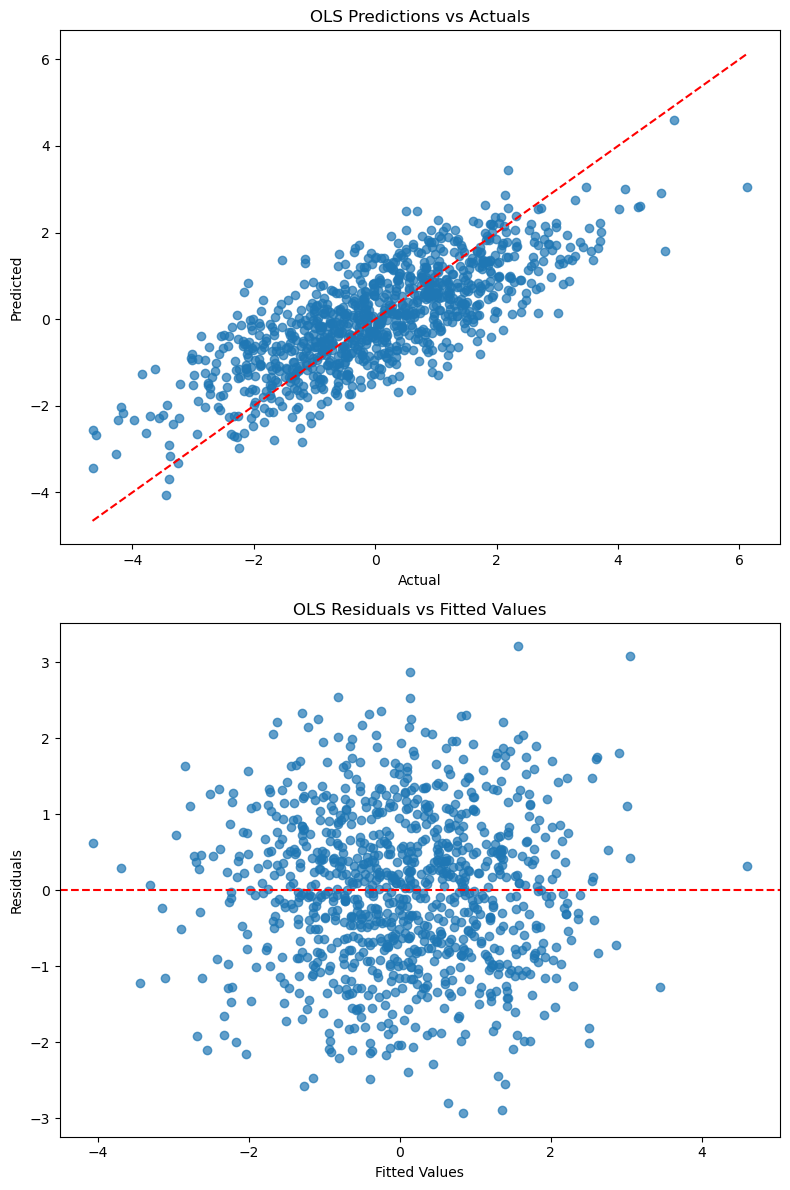

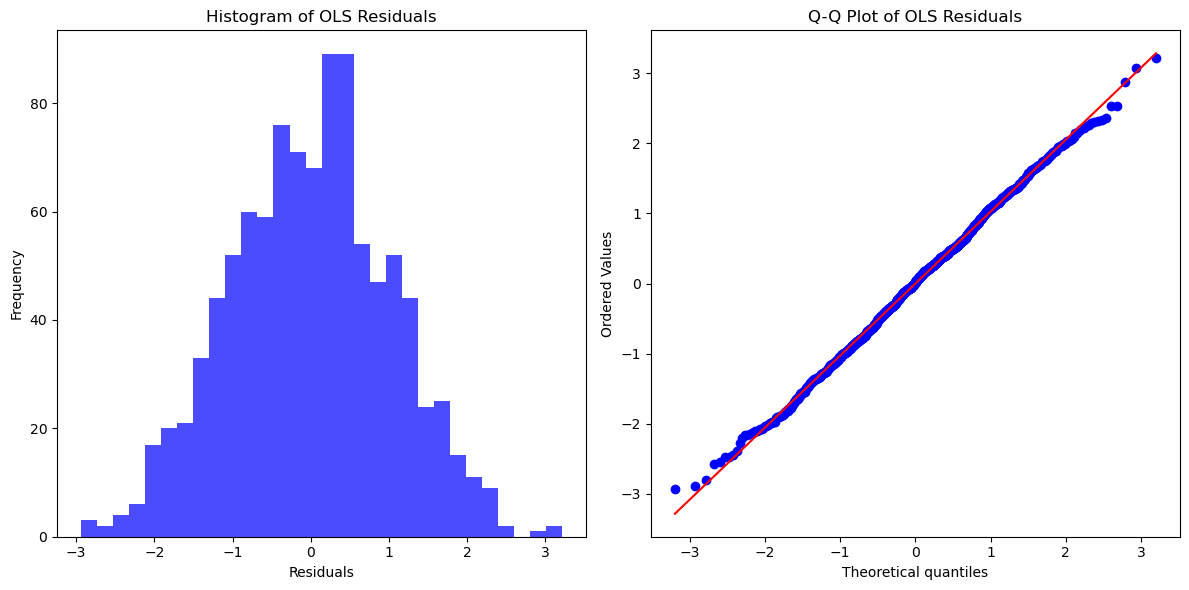

Shapiro-Wilk Test Statistics: 0.9983772517189714
Shapiro-Wilk Test p-value: 0.4771122979431397


In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.optimize import minimize
from scipy.special import expit

n_groups = 100
n_obs_per_group = 10
n_features = 3
true_beta = np.array([0.5, -1.0, 0.3])

# Generate normally-distributed data
X, y, groups = generate_data(n_groups, n_obs_per_group, n_features, true_beta, distribution='normal')

# Fit OLS
ols = OLS()
ols_beta = ols.fit(X, y)
print("OLS Estimated coefficients:\n", ols_beta)

# Predict using OLS
y_pred_ols = ols.predict(X)

# Calculate residuals
residuals_ols = y - y_pred_ols

# Scatter Plot of the Original Data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], y, c=groups, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Group')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Original Normally-distributed Data')
plt.show()

# Pairplot to Visualize Relationships Between Features and the Response
df = pd.DataFrame(X, columns=[f'Feature {i+1}' for i in range(n_features)])
df['Response'] = y
df['Group'] = groups
sns.pairplot(df, hue='Group', corner=True)
plt.suptitle('Pairplot of Features and Response', y=1.02)
plt.show()

# Model Predictions vs. Actual Data for OLS
plt.figure(figsize=(8, 12))

# Predictions vs Actuals
plt.subplot(2, 1, 1)
plt.scatter(y, y_pred_ols, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('OLS Predictions vs Actuals')

# Residuals vs. Fitted Values
plt.subplot(2, 1, 2)
plt.scatter(y_pred_ols, residuals_ols, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('OLS Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Check Residuals for Normality
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_ols, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of OLS Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_ols, dist="norm", plot=plt)
plt.title('Q-Q Plot of OLS Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistics:', stat)
print('Shapiro-Wilk Test p-value:', p_value)

First 10 rows of design matrix (X):
 [[0.        ]
 [0.06346652]
 [0.12693304]
 [0.19039955]
 [0.25386607]
 [0.31733259]
 [0.38079911]
 [0.44426563]
 [0.50773215]
 [0.57119866]]
First 10 elements of response vector (y):
 [0.04967142 0.04959749 0.19136131 0.34155423 0.22773265 0.28861975
 0.52958374 0.50653839 0.4392493  0.59489682]
OLS Estimated coefficients:
 [ 0.9090676  -0.29267074]


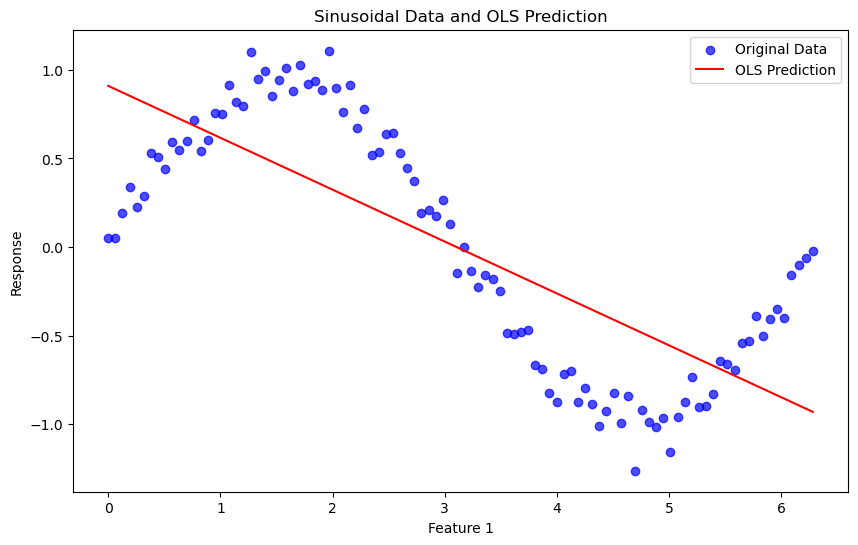

/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/LongDataAlgDev/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


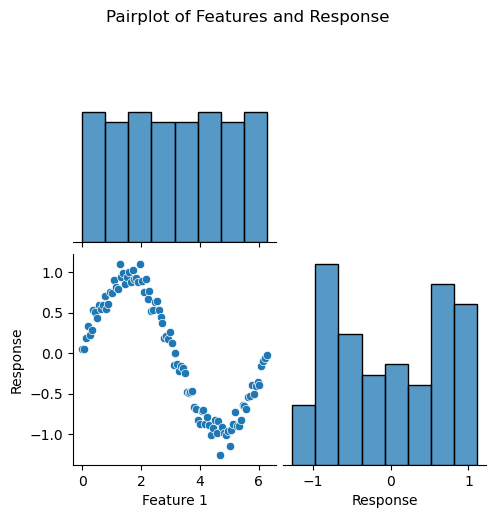

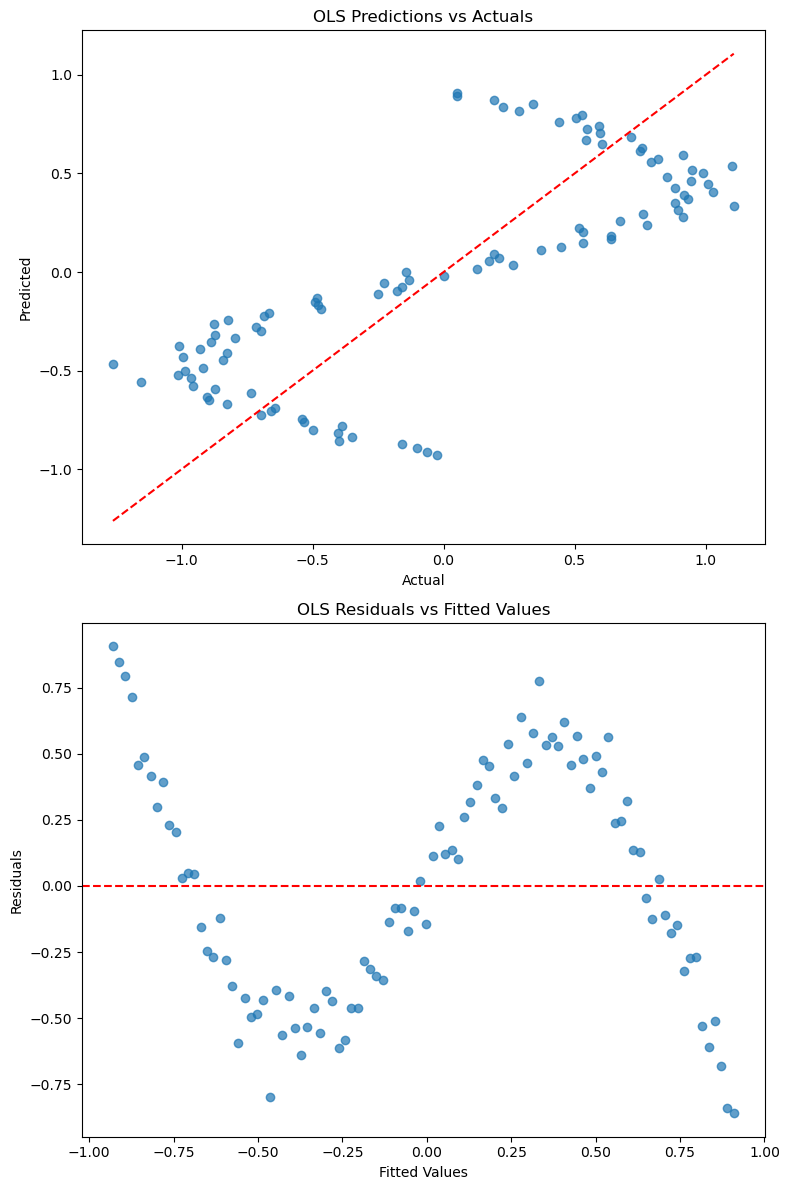

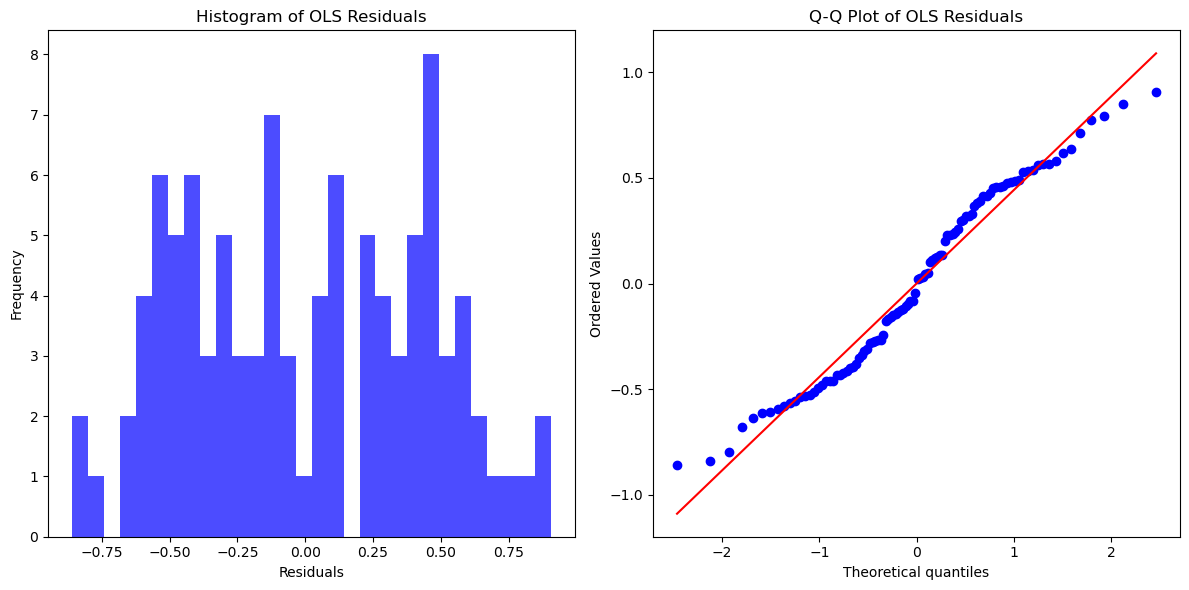

Shapiro-Wilk Test Statistics: 0.9658177589423187
Shapiro-Wilk Test p-value: 0.010678371331303362


In [156]:
def generate_sinusoidal_data(n_samples, n_features, noise_std=0.1):
    np.random.seed(42)
    X = np.linspace(0, 2 * np.pi, n_samples)
    X = np.column_stack([X] + [np.random.randn(n_samples) for _ in range(n_features - 1)])
    y = np.sin(X[:, 0]) + noise_std * np.random.randn(n_samples)
    return X, y

n_samples = 100
n_features = 1

# Generate sinusoidal data
X, y = generate_sinusoidal_data(n_samples, n_features)
print("First 10 rows of design matrix (X):\n", X[:10])
print("First 10 elements of response vector (y):\n", y[:10])

# Fit OLS
ols = OLS()
ols_beta = ols.fit(X, y)
print("OLS Estimated coefficients:\n", ols_beta)

# Predict using OLS
y_pred_ols = ols.predict(X)

# Calculate residuals
residuals_ols = y - y_pred_ols

import seaborn as sns

# Scatter Plot of the Original Data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y, c='blue', alpha=0.7, label='Original Data')
plt.plot(X[:, 0], y_pred_ols, color='red', label='OLS Prediction')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Sinusoidal Data and OLS Prediction')
plt.legend()
plt.show()

# Pairplot to Visualize Relationships Between Features and the Response
df = pd.DataFrame(X, columns=[f'Feature {i+1}' for i in range(n_features)])
df['Response'] = y
sns.pairplot(df, corner=True)
plt.suptitle('Pairplot of Features and Response', y=1.02)
plt.show()

# Model Predictions vs. Actual Data for OLS
plt.figure(figsize=(8, 12))

# Predictions vs Actuals
plt.subplot(2, 1, 1)
plt.scatter(y, y_pred_ols, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('OLS Predictions vs Actuals')

# Residuals vs. Fitted Values
plt.subplot(2, 1, 2)
plt.scatter(y_pred_ols, residuals_ols, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('OLS Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Check Residuals for Normality
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_ols, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of OLS Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_ols, dist="norm", plot=plt)
plt.title('Q-Q Plot of OLS Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistics:', stat)
print('Shapiro-Wilk Test p-value:', p_value)



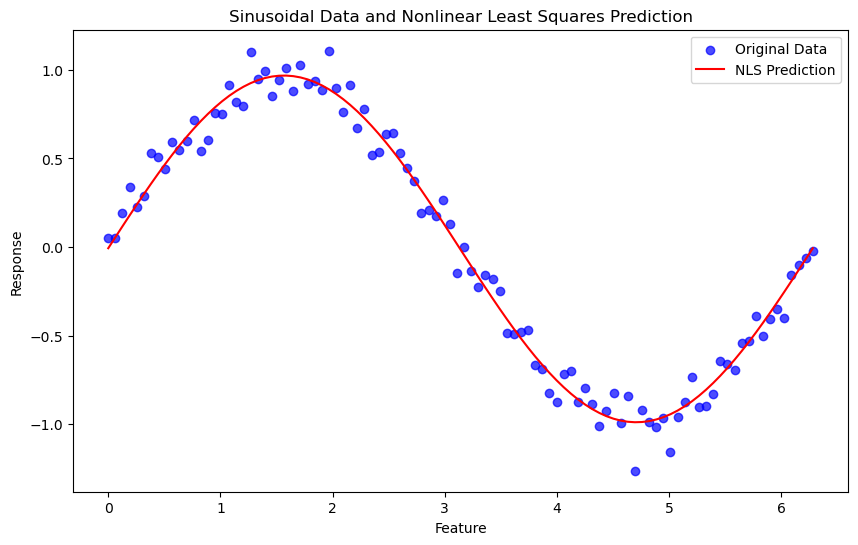

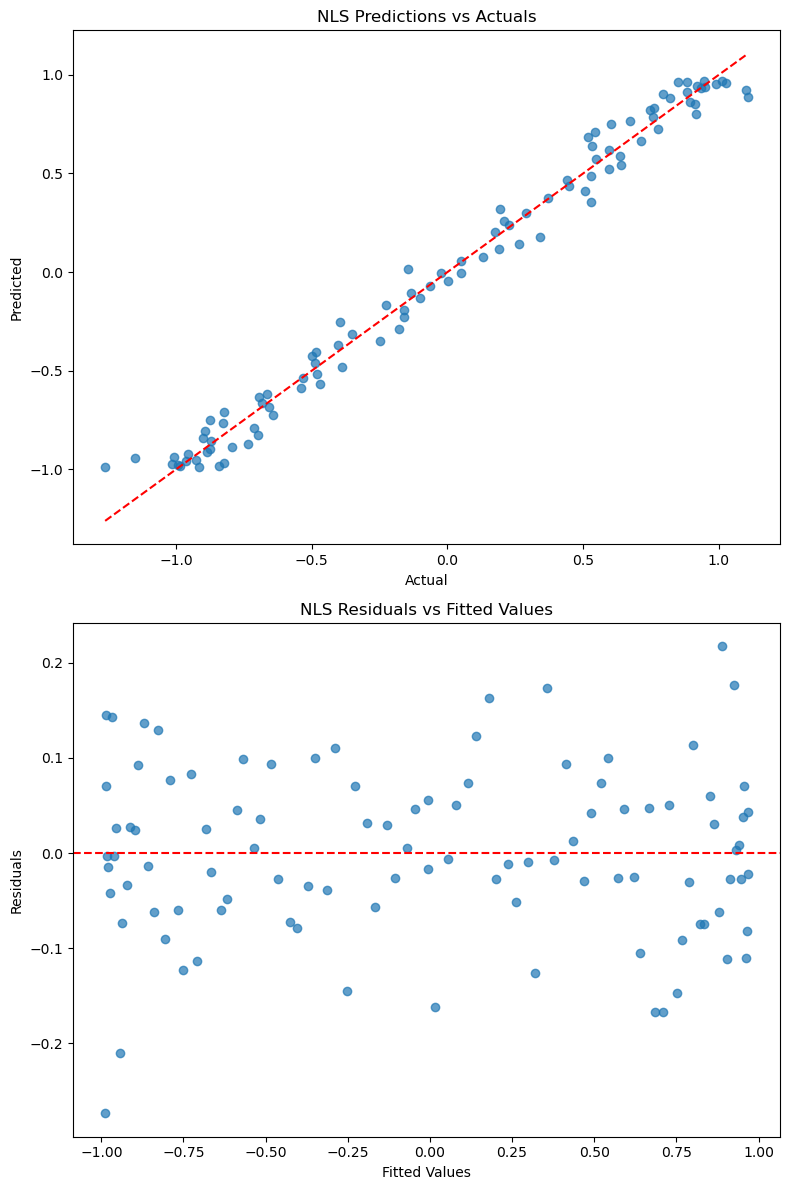

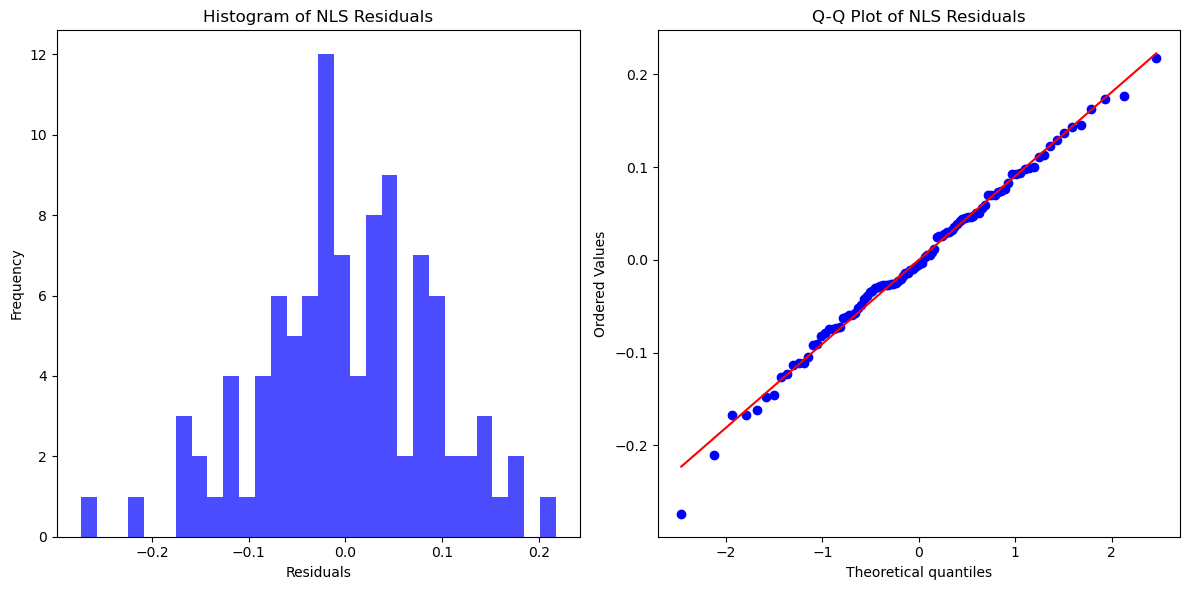

(0.9944771202351866, 0.9592498715126136)

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro

# Generate one-dimensional sinusoidal data
def generate_1d_sinusoidal_data(n_samples, noise_std=0.1):
    np.random.seed(42)
    X = np.linspace(0, 2 * np.pi, n_samples)
    y = np.sin(X) + noise_std * np.random.randn(n_samples)
    return X, y

n_samples = 100
X, y = generate_1d_sinusoidal_data(n_samples)

# Define the sinusoidal model function
def sinusoidal_model(X, amplitude, phase, offset):
    return amplitude * np.sin(X + phase) + offset

# Fit the nonlinear least squares model
initial_guess = [1, 0, 0]
params, params_covariance = curve_fit(sinusoidal_model, X, y, p0=initial_guess)

# Predict using the fitted model
y_pred_nls = sinusoidal_model(X, *params)

# Calculate residuals
residuals_nls = y - y_pred_nls

# Scatter Plot of the Original Data and Nonlinear Least Squares Fit
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c='blue', alpha=0.7, label='Original Data')
plt.plot(X, y_pred_nls, color='red', label='NLS Prediction')
plt.xlabel('Feature')
plt.ylabel('Response')
plt.title('Sinusoidal Data and Nonlinear Least Squares Prediction')
plt.legend()
plt.show()

# Predictions vs Actual Data for NLS
plt.figure(figsize=(8, 12))

# Predictions vs Actuals
plt.subplot(2, 1, 1)
plt.scatter(y, y_pred_nls, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('NLS Predictions vs Actuals')

# Residuals vs. Fitted Values
plt.subplot(2, 1, 2)
plt.scatter(y_pred_nls, residuals_nls, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('NLS Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Check Residuals for Normality
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_nls, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of NLS Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_nls, dist="norm", plot=plt)
plt.title('Q-Q Plot of NLS Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_nls)
(stat, p_value)


# Regression Analysis: OLS, Nonlinear Least Squares, GLM, and GEE

This notebook demonstrates various regression techniques, starting with basic Ordinary Least Squares (OLS) regression, moving to nonlinear least squares for sinusoidal data, and then applying Generalized Linear Models (GLM) and Generalized Estimating Equations (GEE) to longitudinal data.

---

## Basic Ordinary Least Squares (OLS) Regression

Let's start with a basic OLS regression on simulated linear data.


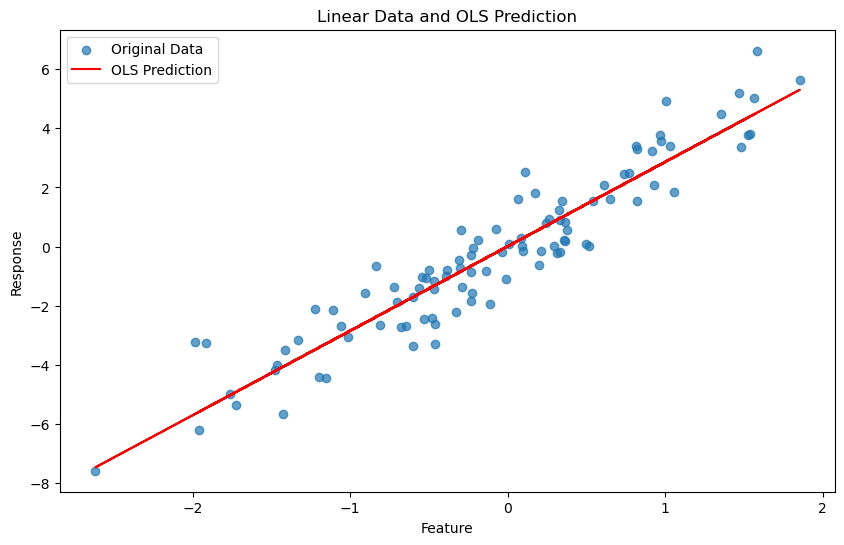

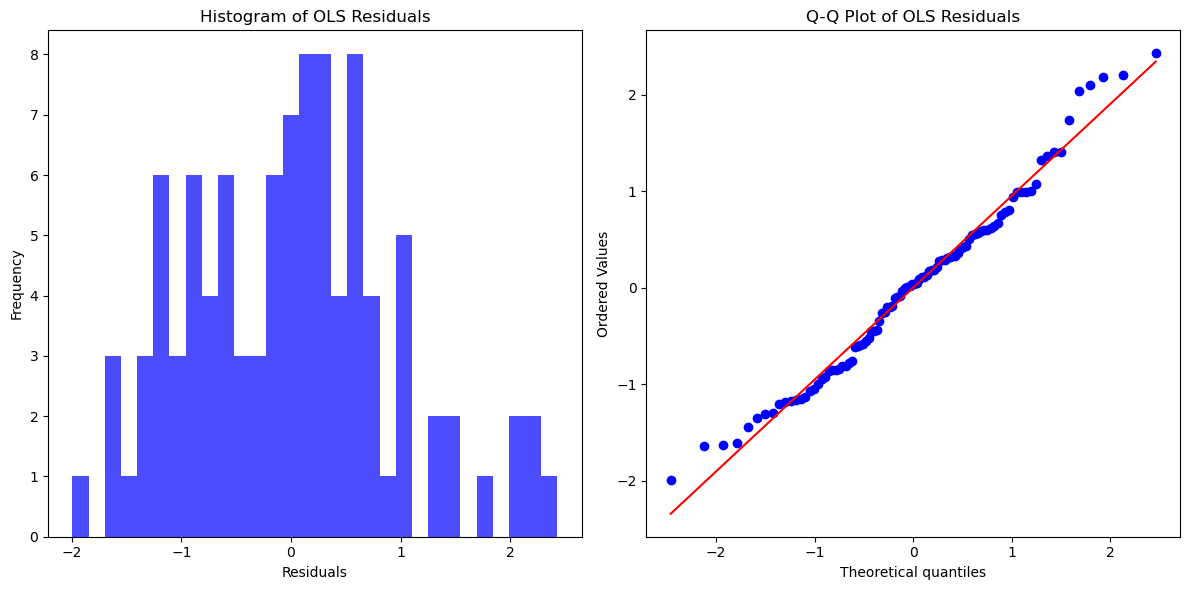

Shapiro-Wilk Test Statistics: 0.9812041523339575
Shapiro-Wilk Test p-value: 0.1648111186961187
R-squared: 0.8829199943498208
MSE: 0.8836324822912885


In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.optimize import curve_fit
from scipy.special import expit
from sklearn.metrics import r2_score, mean_squared_error

# Define OLS Class
class OLS:
    def __init__(self):
        self.beta = None

    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0]), X))
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y
        return self.beta

    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))
        return X @ self.beta

# Generate linear data
np.random.seed(42)
n_samples = 100
X = np.random.randn(n_samples, 1)
y = 3 * X[:, 0] + np.random.randn(n_samples)

# Fit OLS model
ols = OLS()
ols_beta = ols.fit(X, y)
y_pred_ols = ols.predict(X)

# Plot the original data and OLS fit
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, label='Original Data')
plt.plot(X, y_pred_ols, color='red', label='OLS Prediction')
plt.xlabel('Feature')
plt.ylabel('Response')
plt.title('Linear Data and OLS Prediction')
plt.legend()
plt.show()

# Calculate residuals
residuals_ols = y - y_pred_ols

# Residual plots
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_ols, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of OLS Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_ols, dist="norm", plot=plt)
plt.title('Q-Q Plot of OLS Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistics:', stat)
print('Shapiro-Wilk Test p-value:', p_value)

# Goodness of Fit Metrics
r_squared = r2_score(y, y_pred_ols)
mse = mean_squared_error(y, y_pred_ols)
print(f'R-squared: {r_squared}')
print(f'MSE: {mse}')

## Nonlinear Least Squares with Sinusoidal Data

Next, we'll generate sinusoidal data and fit a nonlinear least squares model.


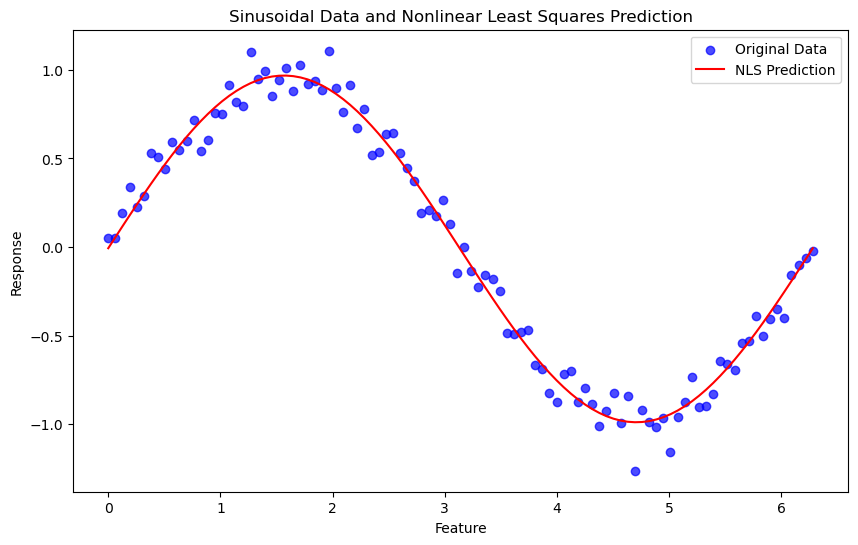

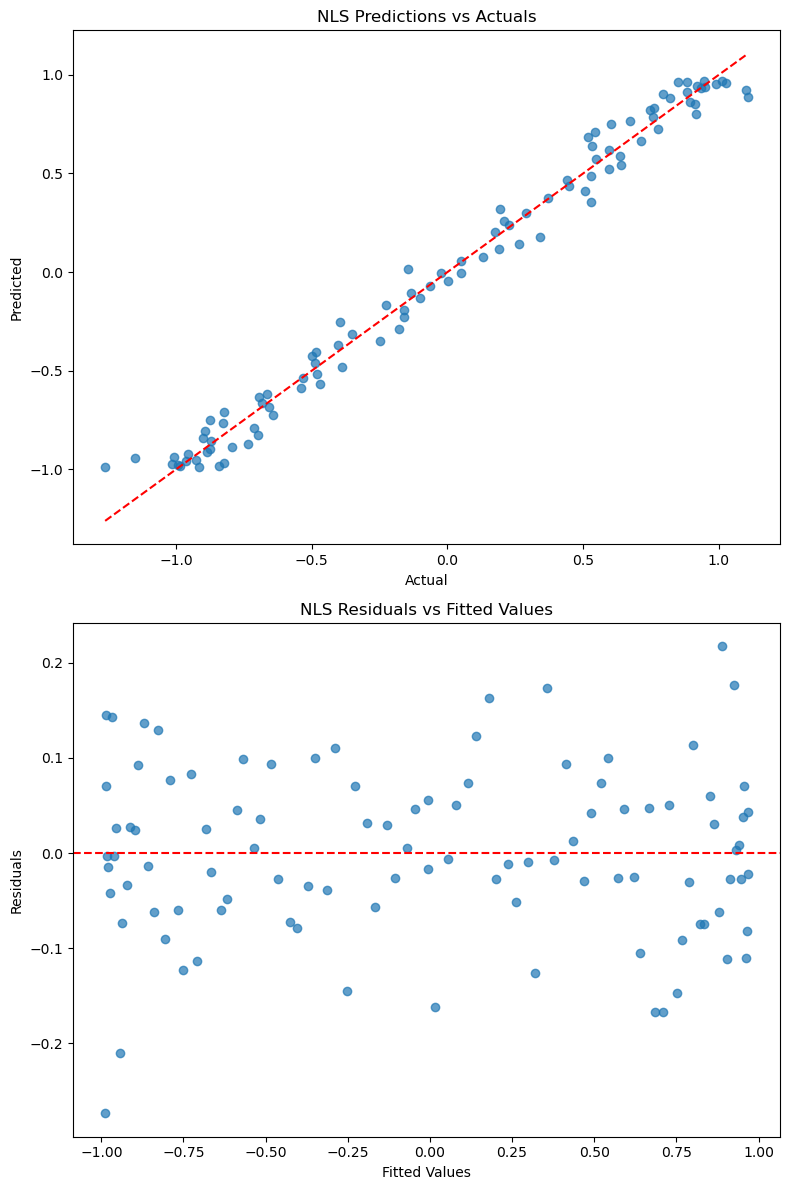

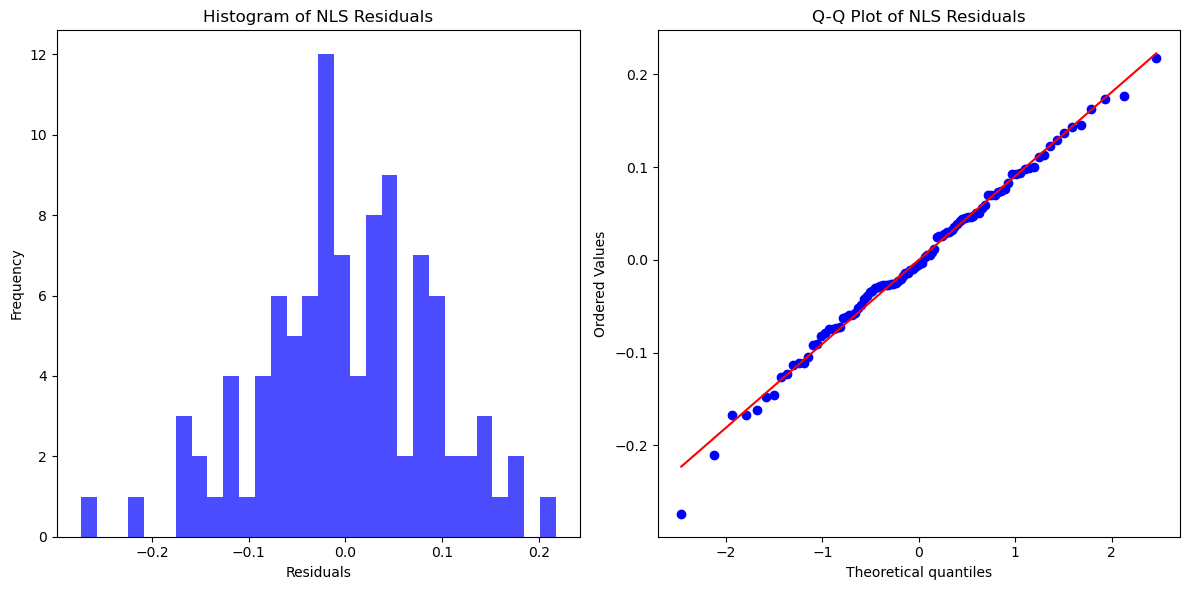

Shapiro-Wilk Test Statistics: 0.9944771202351866
Shapiro-Wilk Test p-value: 0.9592498715126136
R-squared: 0.9835517563273671
MSE: 0.007916843951874551


In [175]:
# Generate one-dimensional sinusoidal data
def generate_1d_sinusoidal_data(n_samples, noise_std=0.1):
    np.random.seed(42)
    X = np.linspace(0, 2 * np.pi, n_samples)
    y = np.sin(X) + noise_std * np.random.randn(n_samples)
    return X, y

n_samples = 100
X, y = generate_1d_sinusoidal_data(n_samples)

# Define the sinusoidal model function
def sinusoidal_model(X, amplitude, phase, offset):
    return amplitude * np.sin(X + phase) + offset

# Fit the nonlinear least squares model
initial_guess = [1, 0, 0]
params, params_covariance = curve_fit(sinusoidal_model, X, y, p0=initial_guess)

# Predict using the fitted model
y_pred_nls = sinusoidal_model(X, *params)

# Calculate residuals
residuals_nls = y - y_pred_nls

# Scatter Plot of the Original Data and Nonlinear Least Squares Fit
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c='blue', alpha=0.7, label='Original Data')
plt.plot(X, y_pred_nls, color='red', label='NLS Prediction')
plt.xlabel('Feature')
plt.ylabel('Response')
plt.title('Sinusoidal Data and Nonlinear Least Squares Prediction')
plt.legend()
plt.show()

# Predictions vs Actual Data for NLS
plt.figure(figsize=(8, 12))

# Predictions vs Actuals
plt.subplot(2, 1, 1)
plt.scatter(y, y_pred_nls, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('NLS Predictions vs Actuals')

# Residuals vs. Fitted Values
plt.subplot(2, 1, 2)
plt.scatter(y_pred_nls, residuals_nls, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('NLS Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Check Residuals for Normality
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_nls, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of NLS Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_nls, dist="norm", plot=plt)
plt.title('Q-Q Plot of NLS Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_nls)
print('Shapiro-Wilk Test Statistics:', stat)
print('Shapiro-Wilk Test p-value:', p_value)

# Goodness of Fit Metrics
r_squared = r2_score(y, y_pred_nls)
mse = mean_squared_error(y, y_pred_nls)
print(f'R-squared: {r_squared}')
print(f'MSE: {mse}')

## OLS for Longitudinal Data

Next, we'll generate longitudinal data and fit an OLS model to show how it might be inadequate for such data.

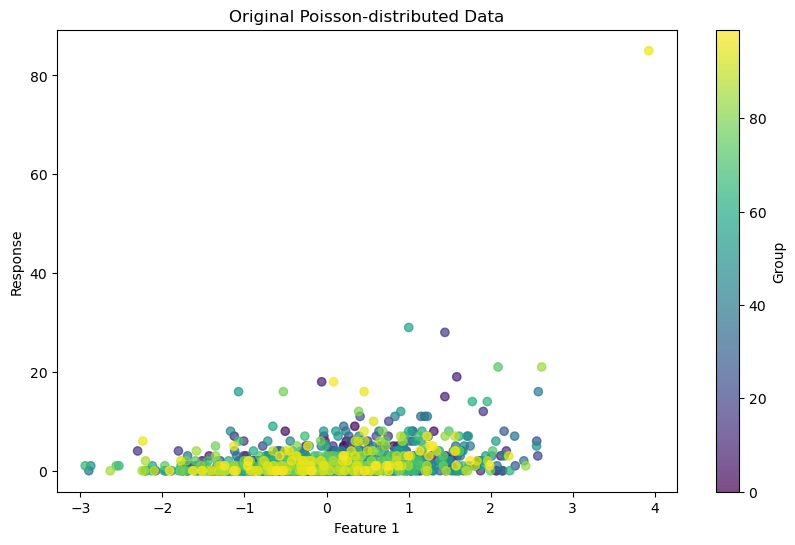

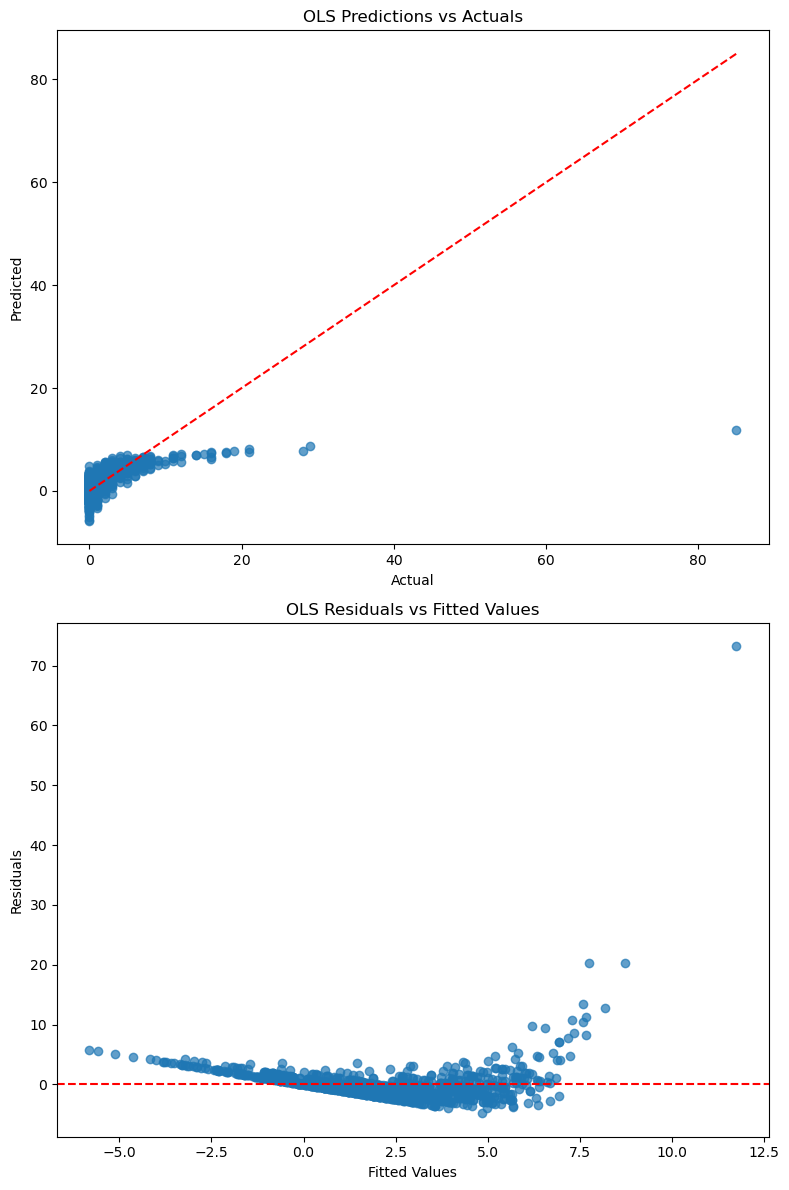

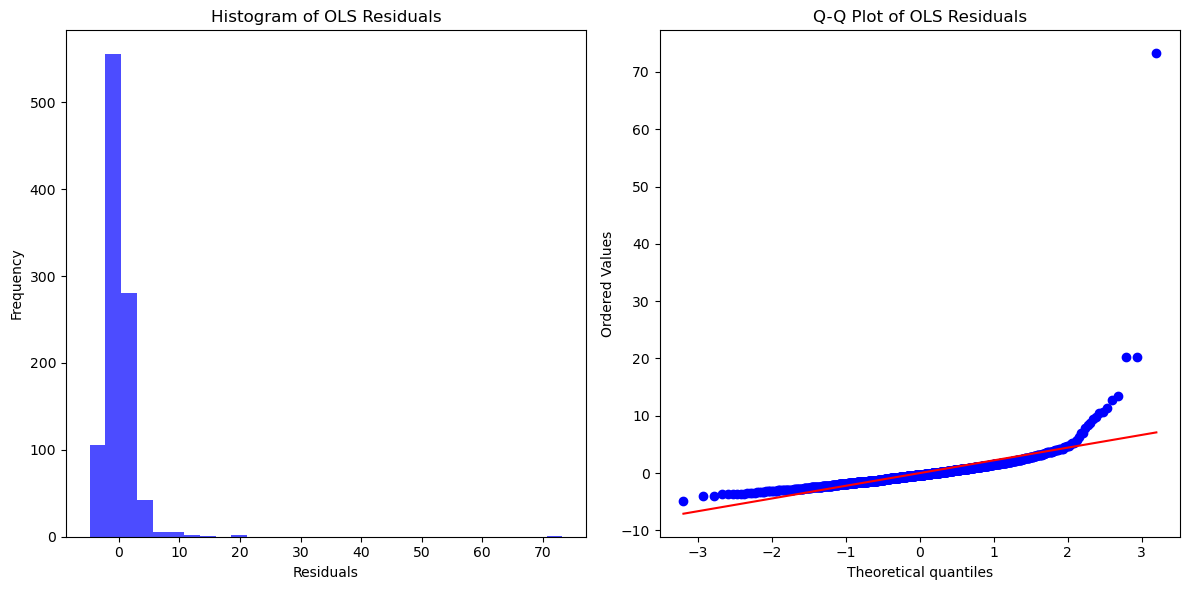

Shapiro-Wilk Test Statistics: 0.4849919248186373
Shapiro-Wilk Test p-value: 8.005111394793278e-47
R-squared: 0.3523087536706483
MSE: 10.245892594808646


In [176]:
def generate_data(n_groups, n_obs_per_group, n_features, true_beta, distribution='poisson'):
    np.random.seed(42)
    X = np.random.randn(n_groups * n_obs_per_group, n_features)
    y = np.zeros(n_groups * n_obs_per_group)
    groups = np.repeat(np.arange(n_groups), n_obs_per_group)
    
    for i in range(n_groups):
        group_idx = (groups == i)
        X_g = X[group_idx]
        eta_g = X_g @ true_beta
        
        if distribution == 'poisson':
            mu_g = np.exp(eta_g)
            y[group_idx] = np.random.poisson(mu_g)
        elif distribution == 'binomial':
            mu_g = expit(eta_g)
            y[group_idx] = np.random.binomial(1, mu_g)
        elif distribution == 'normal':
            mu_g = eta_g  # Identity link for normal distribution
            y[group_idx] = np.random.normal(mu_g, 1)
        elif distribution == 'gamma':
            mu_g = np.exp(eta_g)  # Log link for gamma distribution
            y[group_idx] = np.random.gamma(shape=2, scale=mu_g/2)  # mean=mu_g, variance=mu_g^2/shape
        else:
            raise ValueError("Unsupported distribution type")
    
    return X, y, groups

n_groups = 100
n_obs_per_group = 10
n_features = 3
true_beta = np.array([0.5, -1.0, 0.3])

# Generate Poisson-distributed data
X, y, groups = generate_data(n_groups, n_obs_per_group, n_features, true_beta, distribution='poisson')

# Fit OLS model
ols = OLS()
ols_beta = ols.fit(X, y)
y_pred_ols = ols.predict(X)

# Calculate residuals
residuals_ols = y - y_pred_ols

# Scatter Plot of the Original Data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], y, c=groups, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Group')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Original Poisson-distributed Data')
plt.show()

# Predictions vs Actual Data for OLS
plt.figure(figsize=(8, 12))

# Predictions vs Actuals
plt.subplot(2, 1, 1)
plt.scatter(y, y_pred_ols, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('OLS Predictions vs Actuals')

# Residuals vs. Fitted Values
plt.subplot(2, 1, 2)
plt.scatter(y_pred_ols, residuals_ols, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('OLS Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Check Residuals for Normality
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_ols, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of OLS Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_ols, dist="norm", plot=plt)
plt.title('Q-Q Plot of OLS Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistics:', stat)
print('Shapiro-Wilk Test p-value:', p_value)

# Goodness of Fit Metrics
r_squared = r2_score(y, y_pred_ols)
mse = mean_squared_error(y, y_pred_ols)
print(f'R-squared: {r_squared}')
print(f'MSE: {mse}')



## Generalized Linear Models (GLM)

Next, we'll fit a GLM to the longitudinal data. GLMs are more appropriate for data like this.


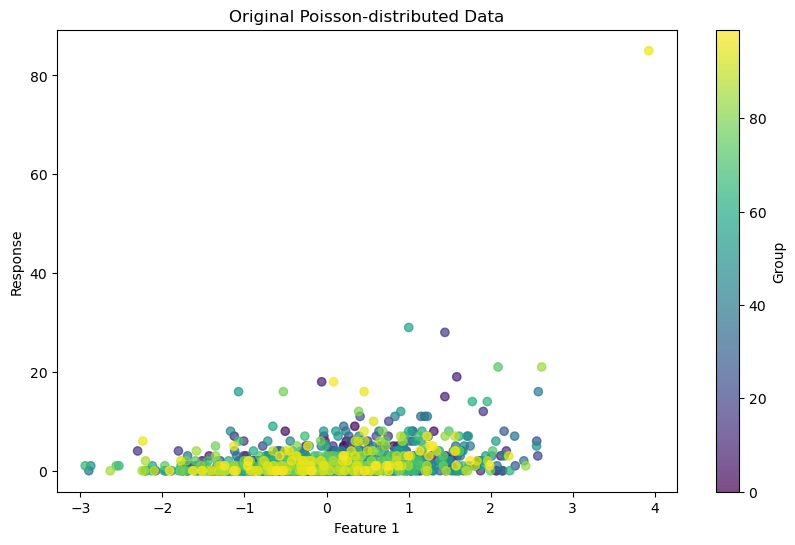

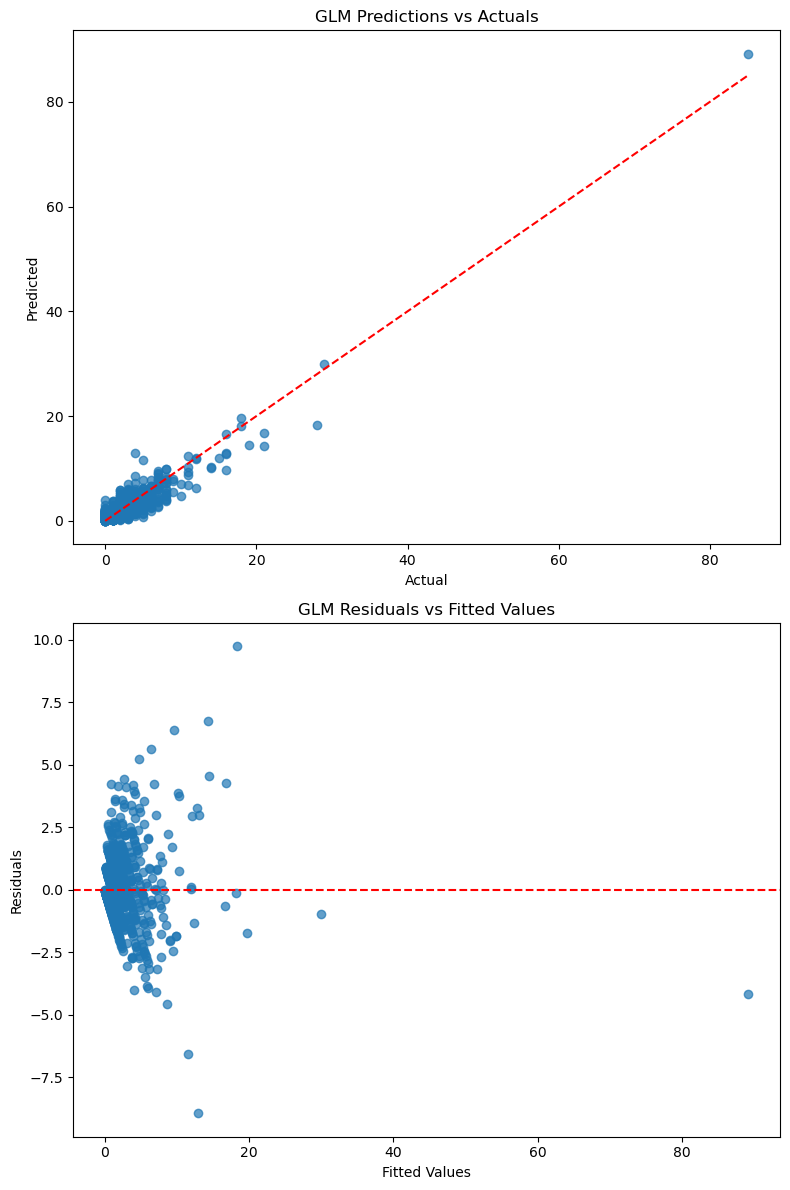

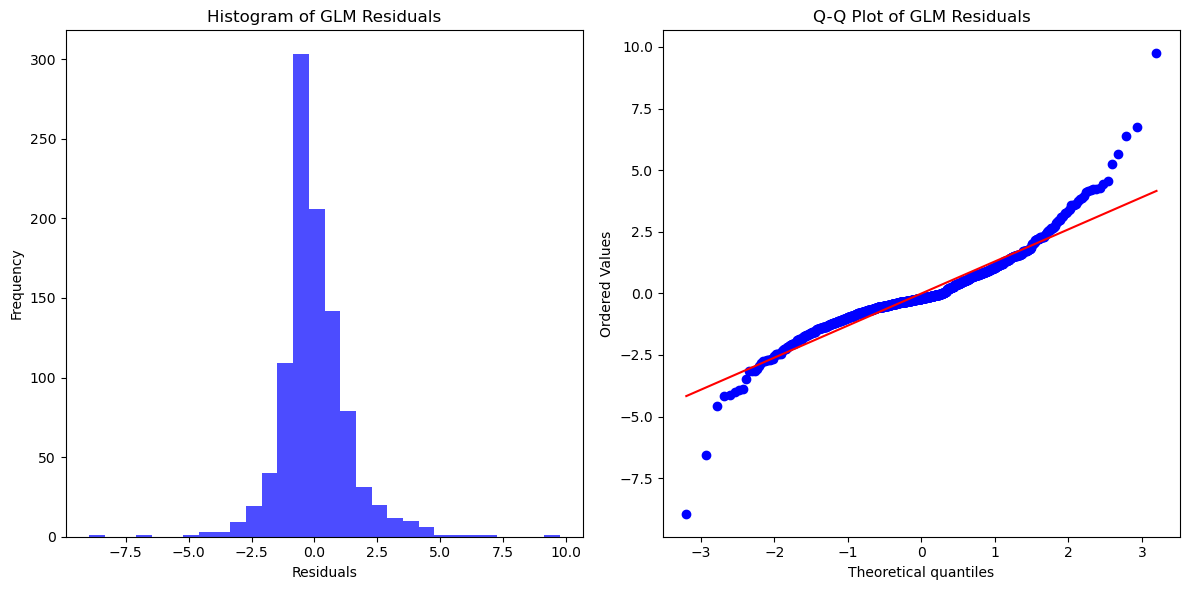

Shapiro-Wilk Test Statistics: 0.9121716545747873
Shapiro-Wilk Test p-value: 1.3741350064883028e-23
R-squared: 0.8826579380284174
MSE: 1.8562458125346615


In [177]:
class GLM:
    def __init__(self, family, link_function):
        self.family = family
        self.link_function = link_function
        self.beta = None

    def fit(self, X, y, max_iter=100, tol=1e-6):
        n_samples, n_features = X.shape
        self.beta = np.zeros(n_features)
        
        for iter in range(max_iter):
            eta = X @ self.beta
            mu = self.link_function.inverse(eta)
            W = np.diag(self.link_function.derivative(mu)**2 / self.family.variance(mu))
            z = eta + (y - mu) / self.link_function.derivative(mu)
            
            beta_new = np.linalg.solve(X.T @ W @ X, X.T @ W @ z)
            
            if np.linalg.norm(beta_new - self.beta) < tol:
                break
            
            self.beta = beta_new
        
        return self.beta

    def predict(self, X):
        eta = X @ self.beta
        return self.link_function.inverse(eta)

class Poisson:
    def variance(self, mu):
        return mu

class Log:
    @staticmethod
    def inverse(eta):
        return np.exp(eta)
    
    @staticmethod
    def derivative(mu):
        return mu

# Fit GLM
glm = GLM(family=Poisson(), link_function=Log())
glm_beta = glm.fit(X, y)
y_pred_glm = glm.predict(X)

# Calculate residuals
residuals_glm = y - y_pred_glm

# Scatter Plot of the Original Data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], y, c=groups, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Group')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Original Poisson-distributed Data')
plt.show()

# Predictions vs Actual Data for GLM
plt.figure(figsize=(8, 12))

# Predictions vs Actuals
plt.subplot(2, 1, 1)
plt.scatter(y, y_pred_glm, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('GLM Predictions vs Actuals')

# Residuals vs. Fitted Values
plt.subplot(2, 1, 2)
plt.scatter(y_pred_glm, residuals_glm, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('GLM Residuals vs Fitted Values')

plt.tight_layout()
plt.show()

# Check Residuals for Normality
plt.figure(figsize=(12, 6))

# Histogram of Residuals
plt.subplot(1, 2, 1)
plt.hist(residuals_glm, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of GLM Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals_glm, dist="norm", plot=plt)
plt.title('Q-Q Plot of GLM Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_glm)
print('Shapiro-Wilk Test Statistics:', stat)
print('Shapiro-Wilk Test p-value:', p_value)

# Goodness of Fit Metrics
r_squared = r2_score(y, y_pred_glm)
mse = mean_squared_error(y, y_pred_glm)
print(f'R-squared: {r_squared}')
print(f'MSE: {mse}')


## Generalized Estimating Equations (GEE)

Finally, we'll fit a GEE model to the longitudinal data using different correlation structures.


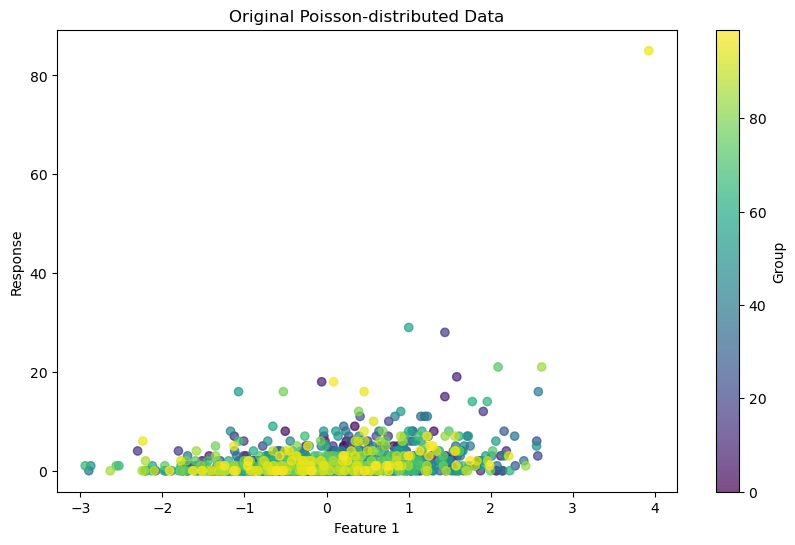

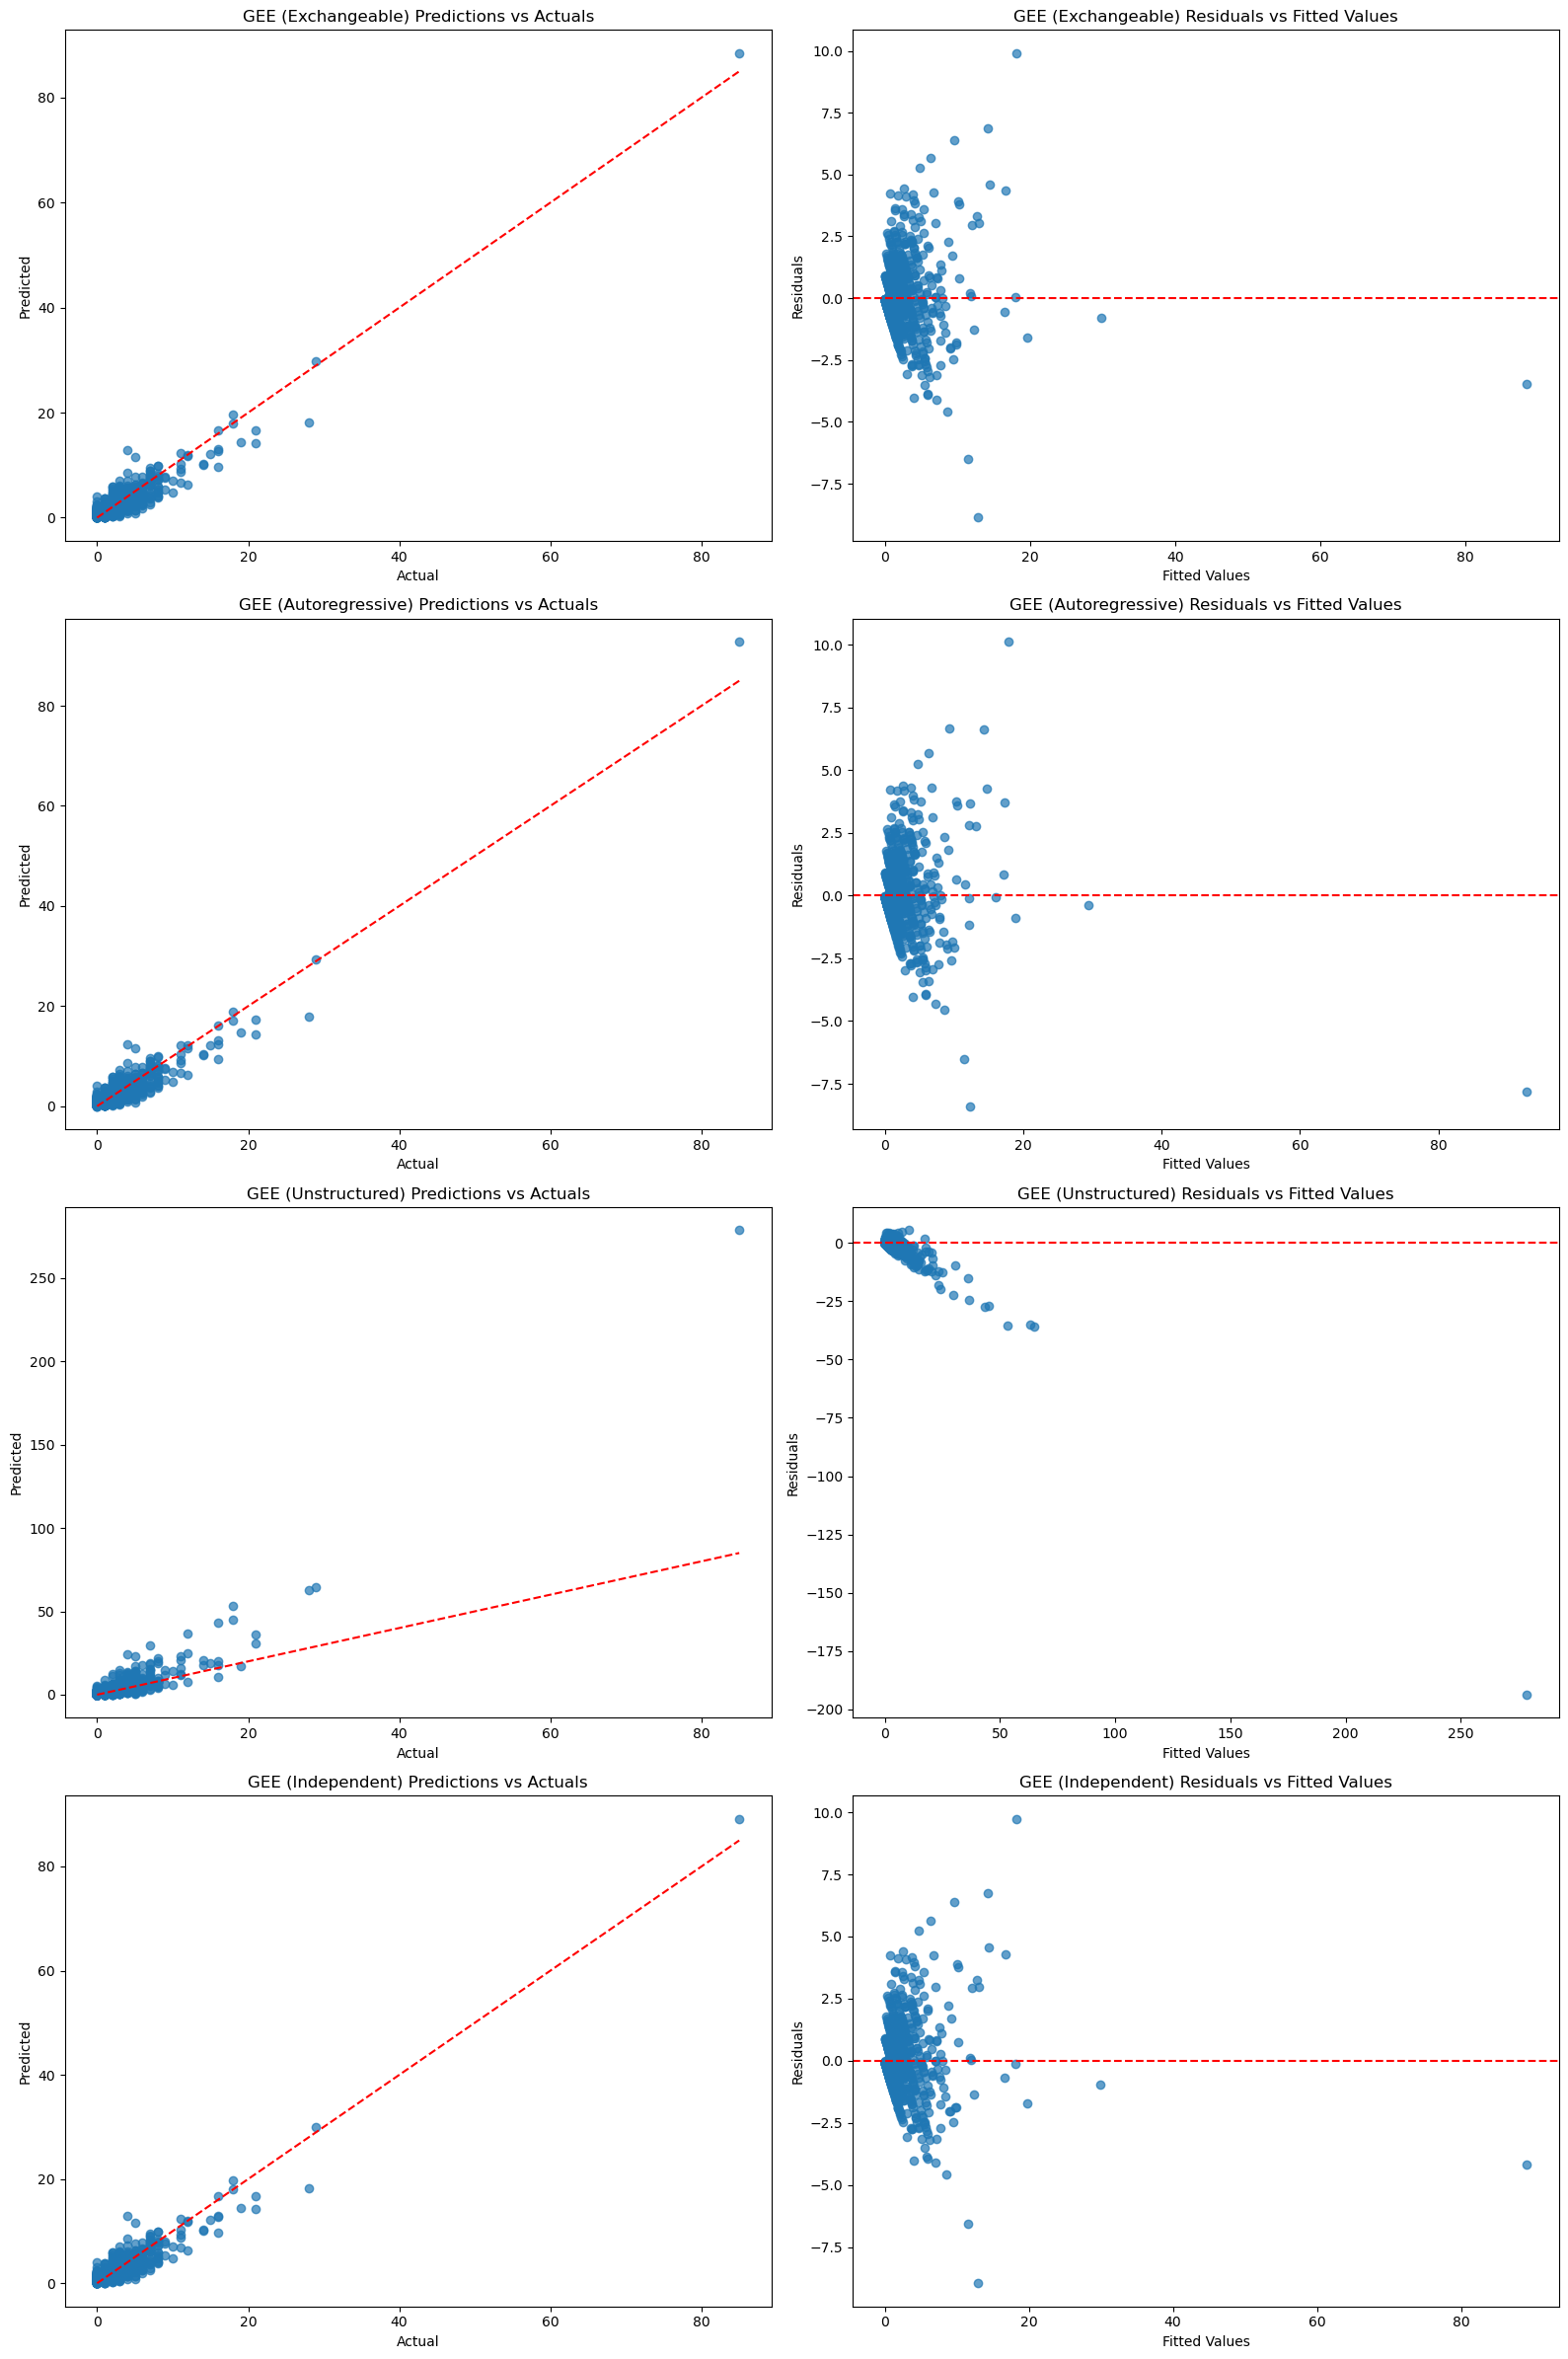

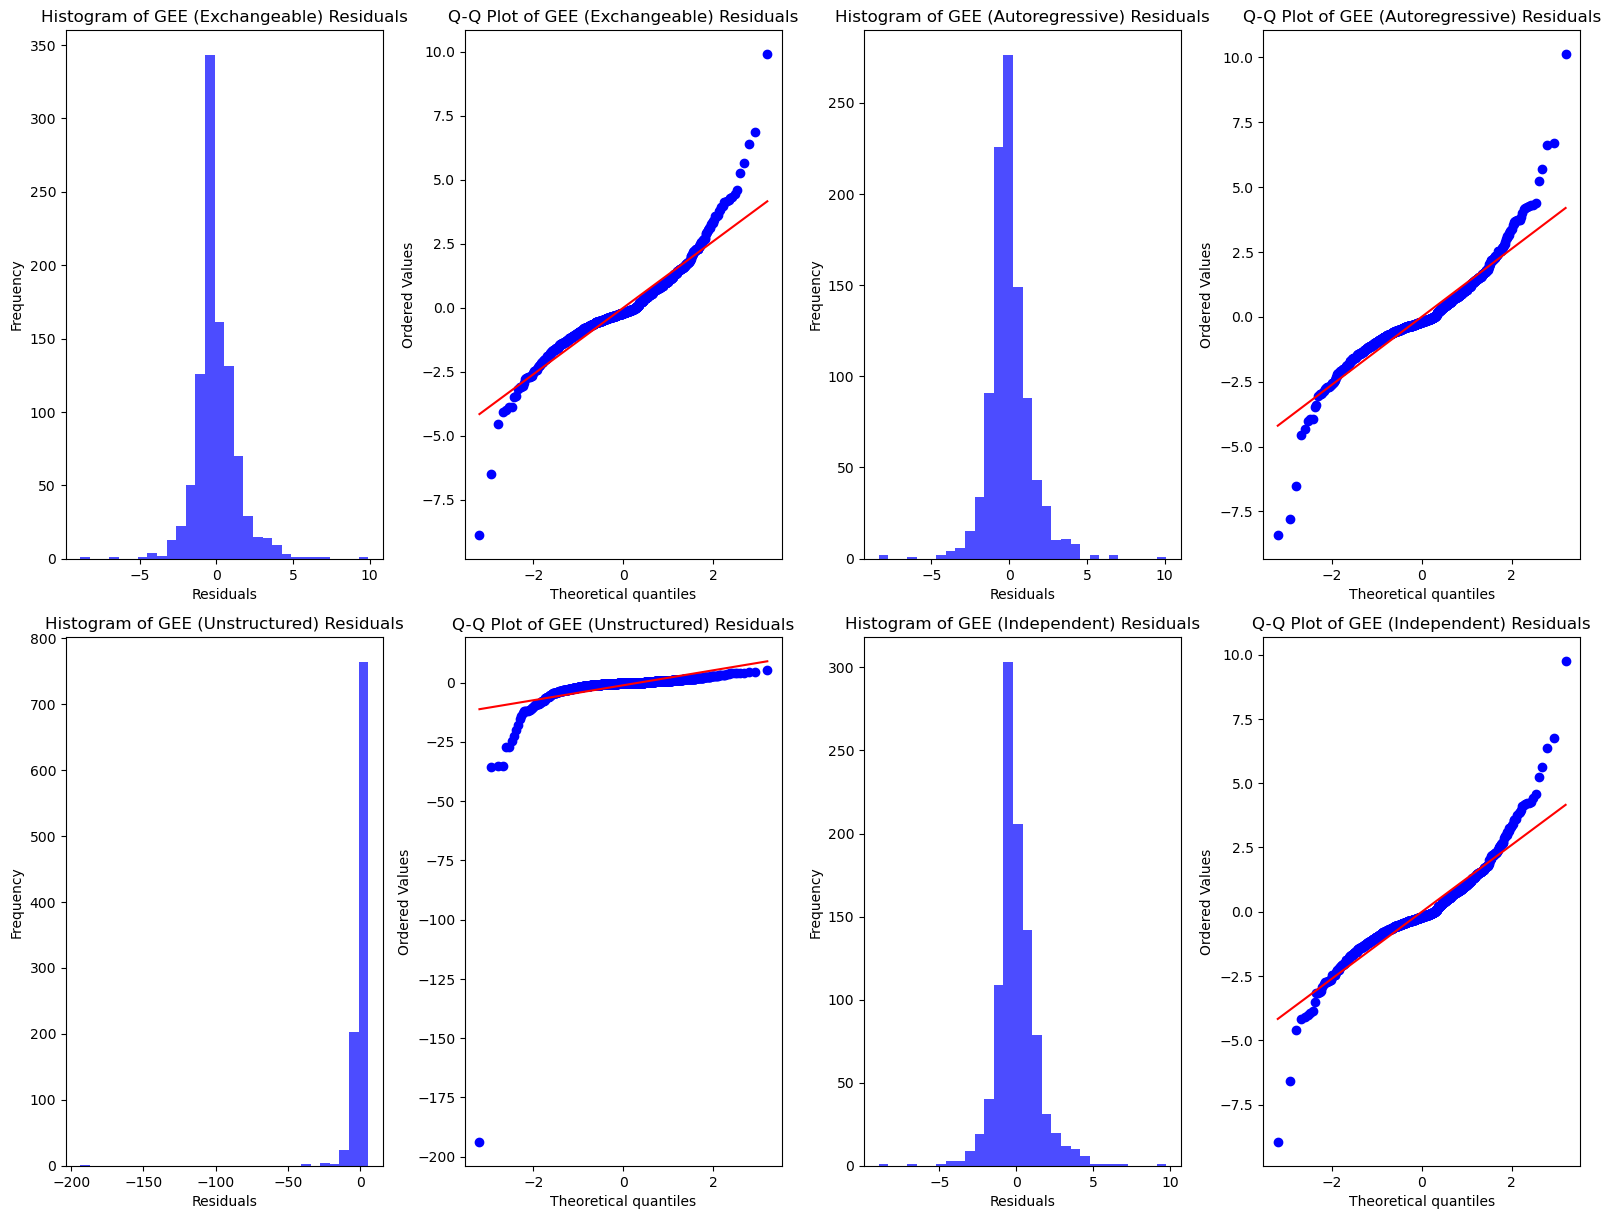

GEE (Exchangeable) Shapiro-Wilk Test Statistics: 0.9111188271311785
GEE (Exchangeable) Shapiro-Wilk Test p-value: 1.0213435126612404e-23
GEE (Autoregressive) Shapiro-Wilk Test Statistics: 0.9052023893340811
GEE (Autoregressive) Shapiro-Wilk Test p-value: 2.0220814318720403e-24
GEE (Unstructured) Shapiro-Wilk Test Statistics: 0.2086080864640948
GEE (Unstructured) Shapiro-Wilk Test p-value: 1.0220514466234634e-53
GEE (Independent) Shapiro-Wilk Test Statistics: 0.9121716573826223
GEE (Independent) Shapiro-Wilk Test p-value: 1.3741360987533348e-23
GEE (Exchangeable) R-squared: 0.8827802497793863
GEE (Exchangeable) MSE: 1.8543109507149107
GEE (Autoregressive) R-squared: 0.8800518075475233
GEE (Autoregressive) MSE: 1.8974724512249737
GEE (Unstructured) R-squared: -2.176866647468594
GEE (Unstructured) MSE: 50.255171182970436
GEE (Independent) R-squared: 0.8826579384463816
GEE (Independent) MSE: 1.8562458059228442


In [178]:
class GEE:
    def __init__(self, family, link_function, corr_structure):
        self.family = family
        self.link_function = link_function
        self.corr_structure = corr_structure
        self.beta = None

    def fit(self, X, y, groups, max_iter=100, tol=1e-6):
        unique_groups = np.unique(groups)
        n_features = X.shape[1]
        self.beta = np.zeros(n_features)
        
        for iter in range(max_iter):
            score = np.zeros(n_features)
            fisher_info = np.zeros((n_features, n_features))
            
            for group in unique_groups:
                group_idx = (groups == group)
                X_g = X[group_idx]
                y_g = y[group_idx]
                eta_g = X_g @ self.beta
                mu_g = self.link_function.inverse(eta_g)
                A_g = np.diag(np.sqrt(self.family.variance(mu_g)))
                R_g = self.corr_structure(len(y_g))
                V_g = A_g @ R_g @ A_g + np.eye(len(y_g)) * 1e-6  # Ensure V_g is not singular
                D_g = np.diag(self.link_function.derivative(mu_g)) @ X_g
                
                try:
                    V_g_inv = np.linalg.inv(V_g)
                except np.linalg.LinAlgError:
                    print(f"Singular matrix for group {group}")
                    continue
                
                score += D_g.T @ V_g_inv @ (y_g - mu_g)
                fisher_info += D_g.T @ V_g_inv @ D_g
            
            beta_new = self.beta + np.linalg.solve(fisher_info, score)
            
            if np.linalg.norm(beta_new - self.beta) < tol:
                break
            
            self.beta = beta_new
        
        return self.beta

    def predict(self, X):
        eta = X @ self.beta
        return self.link_function.inverse(eta)

# Define Correlation Structures
def independence(n):
    return np.eye(n)

def exchangeable(n, alpha=0.5):
    return np.full((n, n), alpha) + np.eye(n) * (1 - alpha)

def autoregressive(n, rho=0.5):
    return rho ** np.abs(np.subtract.outer(np.arange(n), np.arange(n)))

def unstructured(n):
    random_matrix = np.random.randn(n, n)
    corr = np.dot(random_matrix, random_matrix.T)  # Make it symmetric and positive semi-definite
    corr /= np.sqrt(np.outer(np.diag(corr), np.diag(corr)))  # Normalize to make the diagonal elements 1
    return corr

# Fit GEE with different correlation structures
gee_exch = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: exchangeable(n, alpha=0.5))
gee_beta_exch = gee_exch.fit(X, y, groups)
y_pred_gee_exch = gee_exch.predict(X)

gee_ar = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: autoregressive(n, rho=0.5))
gee_beta_ar = gee_ar.fit(X, y, groups)
y_pred_gee_ar = gee_ar.predict(X)

gee_un = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: unstructured(n))
gee_beta_un = gee_un.fit(X, y, groups)
y_pred_gee_un = gee_un.predict(X)

gee_un = GEE(family=Poisson(), link_function=Log(), corr_structure=lambda n: independence(n))
gee_beta_ind = gee_ind.fit(X, y, groups)
y_pred_gee_ind = gee_ind.predict(X)

# Calculate residuals
residuals_gee_exch = y - y_pred_gee_exch
residuals_gee_ar = y - y_pred_gee_ar
residuals_gee_un = y - y_pred_gee_un
residuals_gee_ind = y - y_pred_gee_ind

# Scatter Plot of the Original Data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], y, c=groups, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Group')
plt.xlabel('Feature 1')
plt.ylabel('Response')
plt.title('Original Poisson-distributed Data')
plt.show()

# Model Predictions vs. Actual Data for Each GEE Model
plt.figure(figsize=(16, 24))

# Predictions vs Actuals
models = {
    'GEE (Exchangeable)': (y_pred_gee_exch, residuals_gee_exch),
    'GEE (Autoregressive)': (y_pred_gee_ar, residuals_gee_ar),
    'GEE (Unstructured)': (y_pred_gee_un, residuals_gee_un),
    'GEE (Independent)': (y_pred_gee_ind, residuals_gee_ind)
}

i = 1
for model_name, (pred, res) in models.items():
    plt.subplot(4, 2, i)
    plt.scatter(y, pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name} Predictions vs Actuals')
    i += 2

# Residuals vs. Fitted Values
i = 2
for model_name, (pred, res) in models.items():
    plt.subplot(4, 2, i)
    plt.scatter(pred, res, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residuals vs Fitted Values')
    i += 2

plt.tight_layout()
plt.show()

# Check Residuals for Normality for each GEE model
plt.figure(figsize=(16, 24))

# Residual histograms and Q-Q plots
for i, (model_name, (pred, res)) in enumerate(models.items()):
    plt.subplot(4, 4, i*2 + 1)
    plt.hist(res, bins=30, alpha=0.7, color='blue')
    plt.title(f'Histogram of {model_name} Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.subplot(4, 4, i*2 + 2)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {model_name} Residuals')

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test for each GEE model
for model_name, (pred, res) in models.items():
    stat, p_value = shapiro(res)
    print(f'{model_name} Shapiro-Wilk Test Statistics: {stat}')
    print(f'{model_name} Shapiro-Wilk Test p-value: {p_value}')

# Goodness of Fit Metrics for each GEE model
for model_name, (pred, res) in models.items():
    r_squared = r2_score(y, pred)
    mse = mean_squared_error(y, pred)
    print(f'{model_name} R-squared: {r_squared}')
    print(f'{model_name} MSE: {mse}')
